# Data Analytics: COMP47350 | Homework 2
### Building and evaluating three different prediction. models: Linear Regression, Logistic Regression and Random Forest.
- Each model will be a supervised learning model with an output of binary classification</ul>
#### This homework is split into the following 6 sections, each with subsections regarding specific tasks:
0. Preparing Dataset for Training
1. Data Understanding and Prep
2. Linear Regression Model
3. Logistic Regression Model
4. Random Forest Model
5. Improving Predictive Models
___
Before you start: combine datasets and clean csv according to concpets covered in lectures and labs. Then continue on to training for prediction models.
The goal in this homework is to work with the data to build and evaluate prediction models that capture the relationship between the descriptive features and the target feature **death_yn**. For this homework you are asked to use the same dataset allocated to you in Homework1 (you can use your cleaned/prepared CSV from Homework1 or start from the raw dataset, clean it according to concepts covered in the lectures/labs, then use it for training prediction models). To use the 2 individual files allocated for Homework1, you can merge them first, then clean the resulting dataset, before starting on Homework2 requirements.
## 0. Preparing Dataset for training
- concatenate two datasets together
- examine and clean set to use further

In [344]:
#import all modules required for the processes throughout this notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [345]:
#read two csv files and concatenate
df1 = pd.read_csv('covid19-cdc-22200023 copy.csv')
df2 = pd.read_csv('covid19-cdc-22204071.csv')
initial_df = pd.concat([df1, df2], axis=0)

#save as csv file
initial_df.to_csv('covid19-cdc-unclean-concat.csv', index=False)

#check row and column count is what it should be
initial_df.shape

(40000, 19)

In [346]:
initial_df.dtypes

case_month                          object
res_state                           object
state_fips_code                    float64
res_county                          object
county_fips_code                   float64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
process                             object
exposure_yn                         object
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
dtype: object

I will now fix up the datatypes and create groups for categorical and numeric data.

In [347]:
# grouping features into correct categories by changing types
initial_df['state_fips_code'] = initial_df['state_fips_code'].astype('object')
initial_df['county_fips_code'] = initial_df['county_fips_code'].astype('object')

category_columns = initial_df.select_dtypes(['object']).columns

for column in category_columns:
    initial_df[column] = initial_df[column].astype('category')
    
numeric_columns = initial_df.select_dtypes(['float64']).columns
initial_df.dtypes

case_month                         category
res_state                          category
state_fips_code                    category
res_county                         category
county_fips_code                   category
age_group                          category
sex                                category
race                               category
ethnicity                          category
case_positive_specimen_interval     float64
case_onset_interval                 float64
process                            category
exposure_yn                        category
current_status                     category
symptom_status                     category
hosp_yn                            category
icu_yn                             category
death_yn                           category
underlying_conditions_yn           category
dtype: object

### 0.1 Exploring the values in the datast to decide how best to handle and clean the data
- looking at the first 5 rows for a general understanding of the kind of values I am working with
- checking unique values in each feature
- exploring values as a proportion of the whole, including NaN
- checking for duplicate rows and columns

In [348]:
#looking at some values for further alteration
initial_df.head(5)

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-03,LA,22.0,ORLEANS,22071.0,65+ years,Female,Black,Non-Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Yes,NaN
1,2020-12,CT,9.0,HARTFORD,9003.0,65+ years,Female,White,Non-Hispanic/Latino,NaN,0.0,Missing,Missing,Probable Case,Symptomatic,Yes,Missing,Yes,NaN
2,2020-12,OK,40.0,OKLAHOMA,40109.0,65+ years,Male,White,Non-Hispanic/Latino,NaN,NaN,Missing,Missing,Probable Case,Unknown,No,Missing,Yes,NaN
3,2021-02,NY,36.0,RICHMOND,36085.0,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Yes,Yes
4,2021-12,OH,39.0,FAIRFIELD,39045.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,NaN,Other,Yes,Laboratory-confirmed case,Symptomatic,Missing,Missing,Yes,Yes


In [349]:
#checcking for types of null values present throughout the category columns
for column in category_columns:
    print(initial_df[column].unique())

['2020-03', '2020-12', '2021-02', '2021-12', '2021-11', ..., '2022-09', '2022-10', '2022-03', '2022-11', '2020-02']
Length: 35
Categories (35, object): ['2020-01', '2020-02', '2020-03', '2020-04', ..., '2022-08', '2022-09', '2022-10', '2022-11']
['LA', 'CT', 'OK', 'NY', 'OH', ..., 'ME', 'VT', 'AK', 'VI', 'GU']
Length: 49
Categories (49, object): ['AK', 'AL', 'AR', 'AZ', ..., 'VT', 'WA', 'WI', 'WY']
[22.0, 9.0, 40.0, 36.0, 39.0, ..., 23.0, 50.0, 2.0, 78.0, 66.0]
Length: 49
Categories (49, float64): [1.0, 2.0, 4.0, 5.0, ..., 56.0, 66.0, 72.0, 78.0]
['ORLEANS', 'HARTFORD', 'OKLAHOMA', 'RICHMOND', 'FAIRFIELD', ..., 'WHARTON', 'PRINCE EDWARD', 'FLUVANNA', 'HICKMAN', 'ABBEVILLE']
Length: 945
Categories (944, object): ['ABBEVILLE', 'ACCOMACK', 'ADA', 'ADAIR', ..., 'YELLOWSTONE', 'YOLO', 'YORK', 'YUMA']
[22071.0, 9003.0, 40109.0, 36085.0, 39045.0, ..., 51147.0, 51065.0, 47081.0, 19187.0, 45001.0]
Length: 1348
Categories (1347, float64): [1003.0, 1009.0, 1015.0, 1017.0, ..., 56025.0, 56029.0, 5

Checking for duplicate rows and columns.

In [350]:
print("Number of duplicate rows:", initial_df.duplicated().sum())

Number of duplicate rows: 3699


In [351]:
dfT = initial_df.T
print("Number of duplicate columns:", dfT.duplicated().sum())

Number of duplicate columns: 0


### 0.2 Exploring data statistics like mode and frequency to better understand the set and decide what to do with it.

In [352]:
initial_df_table_categ = initial_df[category_columns].describe().T
initial_df_table_categ

,count,unique,top,freq
case_month,40000,35,2022-01,5189
res_state,40000,49,NY,4284
state_fips_code,40000.0,49.0,36.0,4284.0
res_county,37635,944,MIAMI-DADE,845
county_fips_code,37635.0,1347.0,12086.0,845.0
age_group,39719,5,18 to 49 years,15351
sex,39179,4,Female,19996
race,35378,8,White,24994
ethnicity,34994,4,Non-Hispanic/Latino,24018
process,40000,9,Missing,36446


### 0.3 Preparing and populating a table for storing data on the mode and 2nd mode in our dataset
- prepare and fill table for mode data
- create feature %missing and add to dataframe

In [353]:
initial_df_category_mode = pd.DataFrame(index = initial_df_table_categ.index, columns=['mode','freq_mode','%mode','2ndmode','freq2ndmode','%2ndmode'])
initial_df_category_mode

,mode,freq_mode,%mode,2ndmode,freq2ndmode,%2ndmode
case_month,NaN,NaN,NaN,NaN,NaN,NaN
res_state,NaN,NaN,NaN,NaN,NaN,NaN
state_fips_code,NaN,NaN,NaN,NaN,NaN,NaN
res_county,NaN,NaN,NaN,NaN,NaN,NaN
county_fips_code,NaN,NaN,NaN,NaN,NaN,NaN
age_group,NaN,NaN,NaN,NaN,NaN,NaN
sex,NaN,NaN,NaN,NaN,NaN,NaN
race,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,NaN,NaN,NaN,NaN,NaN,NaN
process,NaN,NaN,NaN,NaN,NaN,NaN


In [354]:
for column in category_columns:
    initial_df_category_mode.loc[column]['mode'] = initial_df[column].value_counts().keys()[0]
    initial_df_category_mode.loc[column]['freq_mode'] = initial_df[column].value_counts()[initial_df_category_mode.loc[column]['mode']]
    initial_df_category_mode.loc[column]['%mode'] = initial_df[column].value_counts(normalize=True)[initial_df_category_mode.loc[column]['mode']]

    if initial_df[column].value_counts().size > 1:
        initial_df_category_mode.loc[column]['2ndmode'] = initial_df[column].value_counts().keys()[1]
        initial_df_category_mode.loc[column]['freq_2ndmode'] = initial_df[column].value_counts()[initial_df_category_mode.loc[column]['2ndmode']]
        initial_df_category_mode.loc[column]['%2ndmode'] = initial_df[column].value_counts(normalize=True)[initial_df_category_mode.loc[column]['2ndmode']]
    else: initial_df_category_mode.loc[column] = '-'

In [355]:
initial_df_category_mode

,mode,freq_mode,%mode,2ndmode,freq2ndmode,%2ndmode
case_month,2022-01,5189,0.129725,2020-12,NaN,0.085125
res_state,NY,4284,0.1071,NJ,NaN,0.088625
state_fips_code,36.0,4284,0.1071,34.0,NaN,0.088625
res_county,MIAMI-DADE,845,0.022453,MARICOPA,NaN,0.01953
county_fips_code,12086.0,845,0.022453,4013.0,NaN,0.01953
age_group,18 to 49 years,15351,0.38649,65+ years,NaN,0.315743
sex,Female,19996,0.510375,Male,NaN,0.484443
race,White,24994,0.706484,Black,NaN,0.11411
ethnicity,Non-Hispanic/Latino,24018,0.686346,Unknown,NaN,0.152826
process,Missing,36446,0.91115,Clinical evaluation,NaN,0.04135


In [356]:
#prepare %missing column
category_columns_perc_missing = 100 * (initial_df[category_columns].isnull().sum()/initial_df.shape[0])
initial_df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
initial_df_category_perc_missing

,%missing
case_month,0.0000
res_state,0.0000
state_fips_code,0.0000
res_county,5.9125
county_fips_code,5.9125
age_group,0.7025
sex,2.0525
race,11.5550
ethnicity,12.5150
process,0.0000


In [357]:
#put columns together to prepare final table
initial_df_category_columns_data_quality_report_table = pd.concat([initial_df_table_categ, initial_df_category_mode,initial_df_category_perc_missing], axis=1)
initial_df_category_columns_data_quality_report_table

,count,unique,top,freq,mode,freq_mode,%mode,2ndmode,freq2ndmode,%2ndmode,%missing
case_month,40000,35,2022-01,5189,2022-01,5189,0.129725,2020-12,NaN,0.085125,0.0000
res_state,40000,49,NY,4284,NY,4284,0.1071,NJ,NaN,0.088625,0.0000
state_fips_code,40000.0,49.0,36.0,4284.0,36.0,4284,0.1071,34.0,NaN,0.088625,0.0000
res_county,37635,944,MIAMI-DADE,845,MIAMI-DADE,845,0.022453,MARICOPA,NaN,0.01953,5.9125
county_fips_code,37635.0,1347.0,12086.0,845.0,12086.0,845,0.022453,4013.0,NaN,0.01953,5.9125
age_group,39719,5,18 to 49 years,15351,18 to 49 years,15351,0.38649,65+ years,NaN,0.315743,0.7025
sex,39179,4,Female,19996,Female,19996,0.510375,Male,NaN,0.484443,2.0525
race,35378,8,White,24994,White,24994,0.706484,Black,NaN,0.11411,11.5550
ethnicity,34994,4,Non-Hispanic/Latino,24018,Non-Hispanic/Latino,24018,0.686346,Unknown,NaN,0.152826,12.5150
process,40000,9,Missing,36446,Missing,36446,0.91115,Clinical evaluation,NaN,0.04135,0.0000


In [358]:
#save as new DataFrame for further analysis
initial_df_category_columns_data_quality_report_table.to_csv("Category_Quality_Report_Table.csv", index_label='Feature')

### 0.4 Data Quality Report: Visualisations
Plotting bar charts for all categorical features.

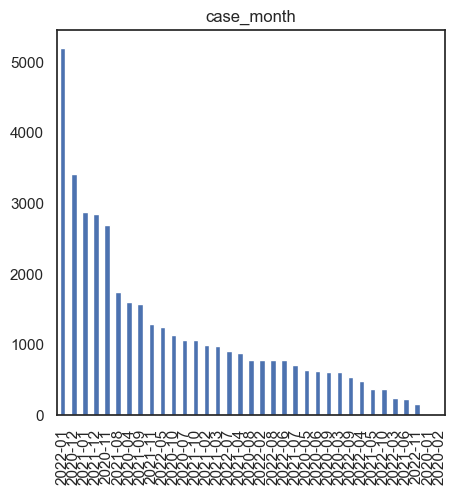

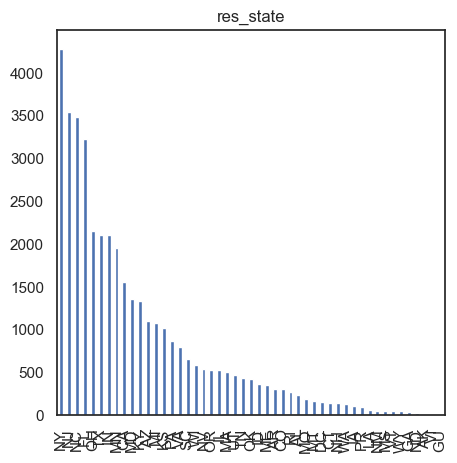

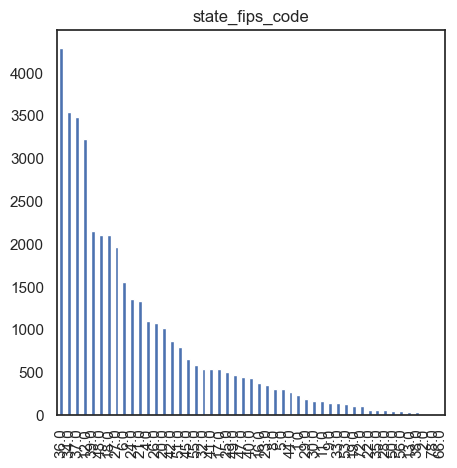

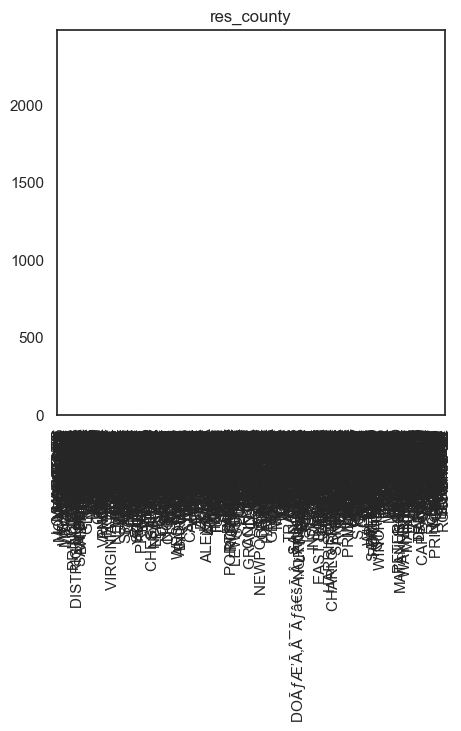

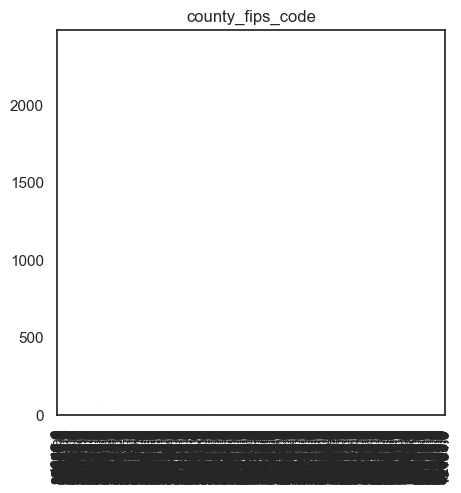

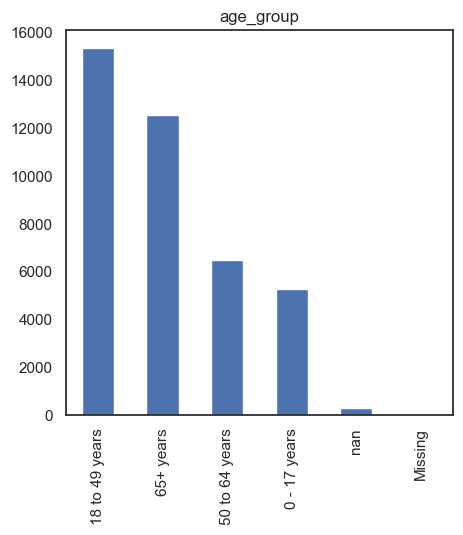

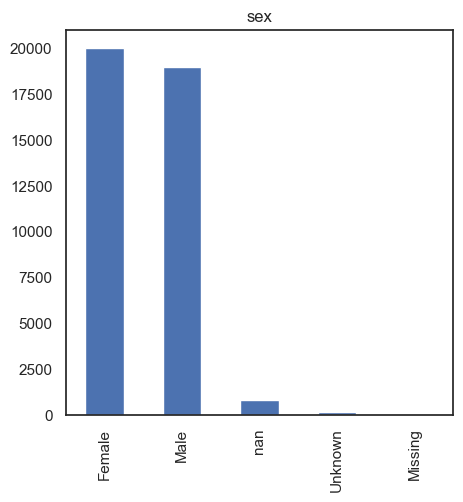

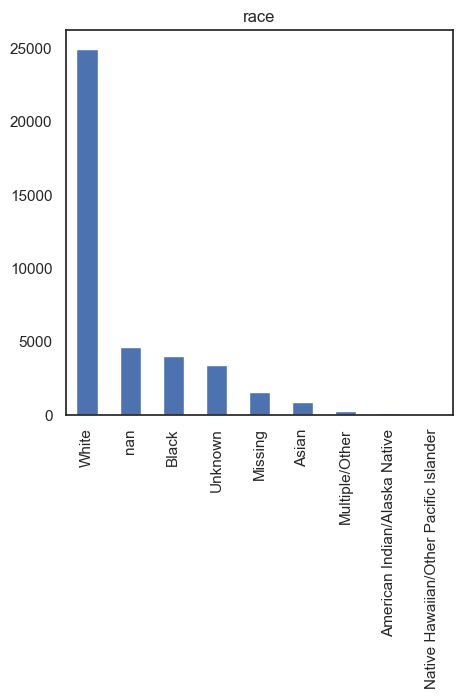

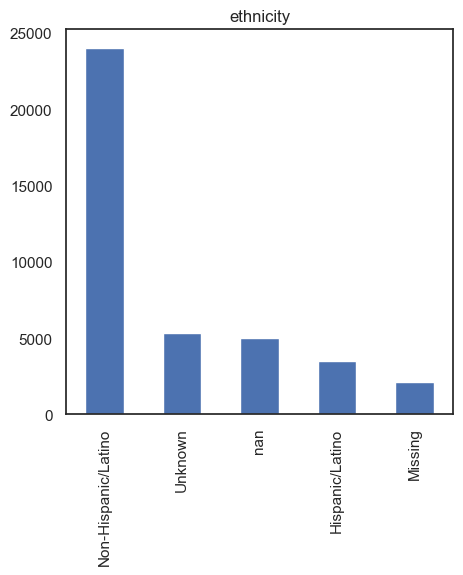

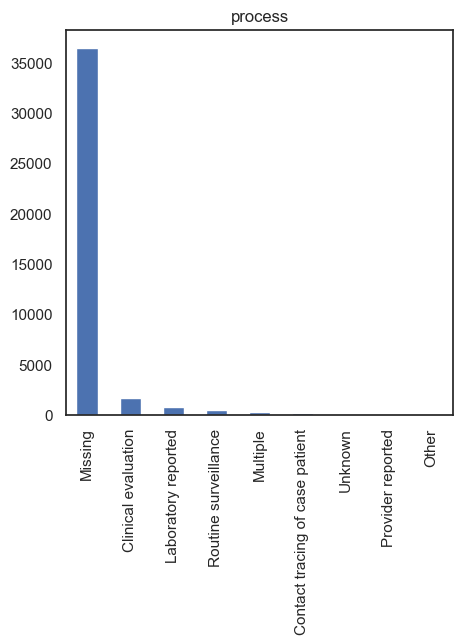

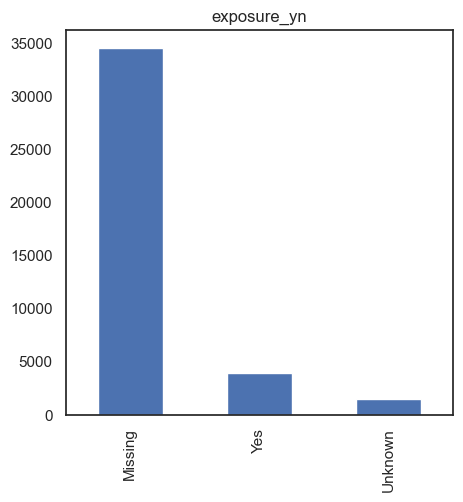

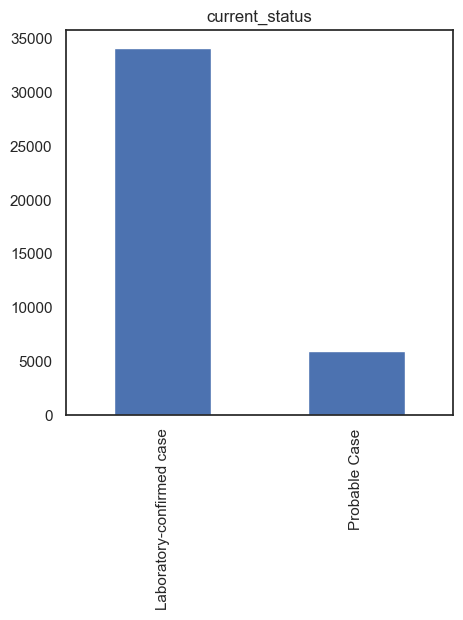

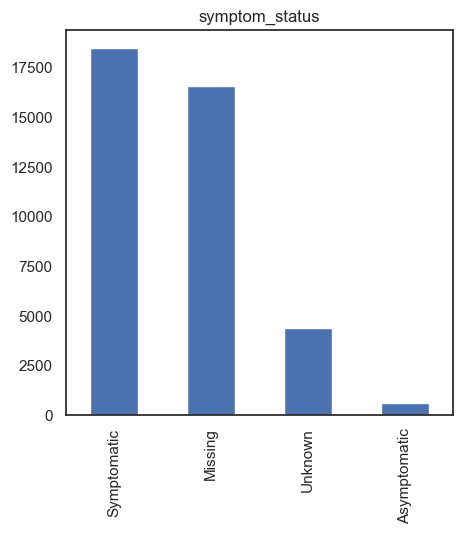

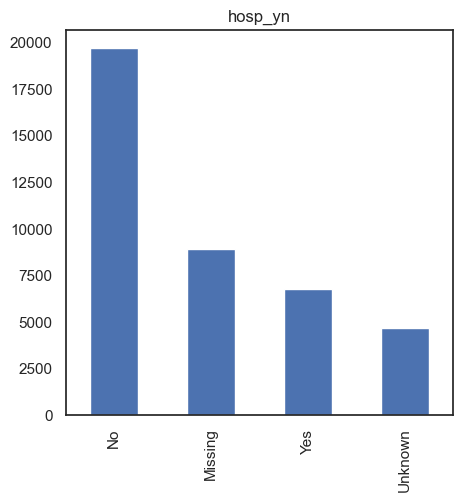

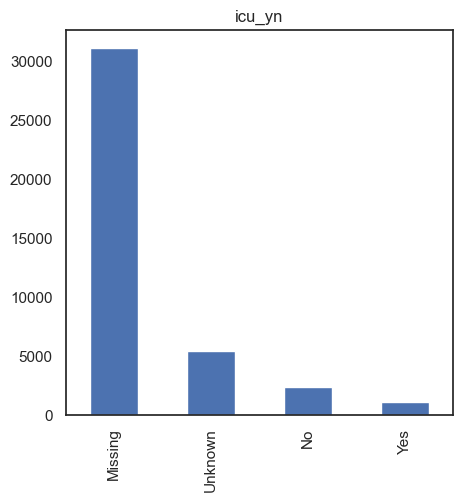

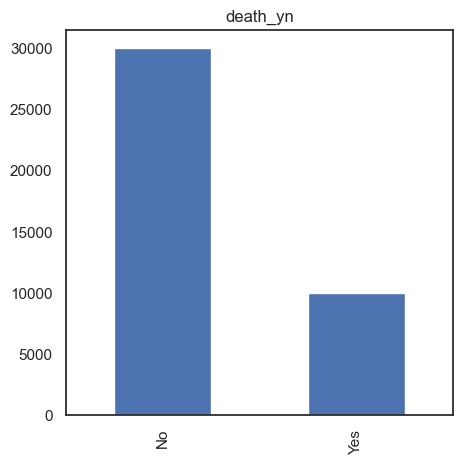

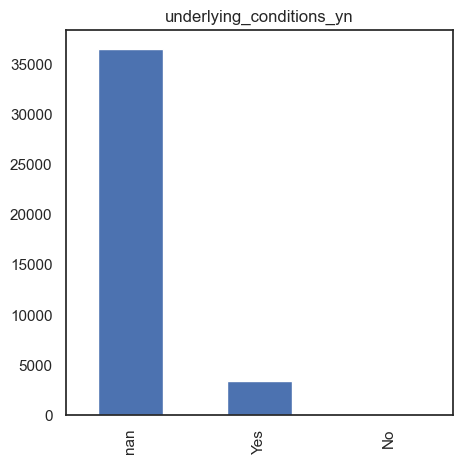

In [359]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('Categorical_Bar_Charts.pdf')
for column in category_columns:
    f = initial_df[column].value_counts(dropna=False).plot(kind='bar', title=column, figsize=(5,5))
    plt.show()
    pp.savefig(f.get_figure())
pp.close()
    

In [360]:
initial_df.nunique()

case_month                           35
res_state                            49
state_fips_code                      49
res_county                          944
county_fips_code                   1347
age_group                             5
sex                                   4
race                                  8
ethnicity                             4
case_positive_specimen_interval      65
case_onset_interval                  58
process                               9
exposure_yn                           3
current_status                        2
symptom_status                        4
hosp_yn                               4
icu_yn                                4
death_yn                              2
underlying_conditions_yn              2
dtype: int64

### 0.5 Implement changes proposed in Sample Data Quality Plan
The changes suggested in the sample DQP seem reasonable when applied to this subset of the data.

In [361]:
#keep a copy of the original data
initial_df_raw = initial_df.copy()

#### 0.5.1 Drop columns:
- case_onset_interval
- case_positive_specimen_interval
- res_state
- res_county
- state_fips_code
- process
- exposure_yn
- symptom_status

In [362]:
initial_df.head(1)

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-03,LA,22.0,ORLEANS,22071.0,65+ years,Female,Black,Non-Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Yes,NaN


In [363]:
initial_df = initial_df.drop(['case_onset_interval','state_fips_code','case_positive_specimen_interval','res_state','res_county','process','exposure_yn','symptom_status'], axis=1)
initial_df.head(1)

,case_month,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-03,22071.0,65+ years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Unknown,Unknown,Yes,NaN


#### 0.5.2 Convert unknown and null to missing, and take missing values into account when analysing data for:
- age_group
- sex
- race
- ethnicity
- hosp_yn
- icu_yn
- underlying_conditions_yn

In [364]:
cols_to_replace = ['age_group','sex','race','ethnicity','hosp_yn','icu_yn','underlying_conditions_yn']
initial_df[cols_to_replace] = initial_df[cols_to_replace].replace({'Unknown': 'Missing', 'NaN':'Missing'})
initial_df['age_group'].head(1)

0    65+ years
Name: age_group, dtype: category
Categories (5, object): ['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years', 'Missing']

In [365]:
#group into category_columns
category_columns = initial_df.select_dtypes(['category']).columns
category_columns

Index(['case_month', 'county_fips_code', 'age_group', 'sex', 'race',
       'ethnicity', 'current_status', 'hosp_yn', 'icu_yn', 'death_yn',
       'underlying_conditions_yn'],
      dtype='object')

In [366]:
#check number of 'NaN' values throughout df
for col in category_columns:
    print(f"Column {col}: {initial_df[col].value_counts().get('NaN', 0)}")

Column case_month: 0
Column county_fips_code: 0
Column age_group: 0
Column sex: 0
Column race: 0
Column ethnicity: 0
Column current_status: 0
Column hosp_yn: 0
Column icu_yn: 0
Column death_yn: 0
Column underlying_conditions_yn: 0


In [367]:
#check number of 'Unknown' values throughout df
for col in initial_df.columns:
    print(f"Column {col}: {initial_df[col].value_counts().get('Unknown', 0)}")

Column case_month: 0
Column county_fips_code: 0
Column age_group: 0
Column sex: 0
Column race: 0
Column ethnicity: 0
Column current_status: 0
Column hosp_yn: 0
Column icu_yn: 0
Column death_yn: 0
Column underlying_conditions_yn: 0


In [368]:
#double check all changes were applied by looking at the first few rows
initial_df.head(5)

,case_month,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-03,22071.0,65+ years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Yes,NaN
1,2020-12,9003.0,65+ years,Female,White,Non-Hispanic/Latino,Probable Case,Yes,Missing,Yes,NaN
2,2020-12,40109.0,65+ years,Male,White,Non-Hispanic/Latino,Probable Case,No,Missing,Yes,NaN
3,2021-02,36085.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Yes,Yes
4,2021-12,39045.0,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Yes,Yes


### 0.6 Save dataframe for Use

In [369]:
initial_df.to_csv('1.0_updated_dataframe_A2.csv', index=False)

# 1. Data Understanding and Prep
Exploring the relationships between feature pairs and selecting/transforming promising features based on a training set.
- read file 
- explore data types and values

In [370]:
#read in the dataframe
df = pd.read_csv("1.0_updated_dataframe_A2.csv")
df.head(5)

,case_month,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-03,22071.0,65+ years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Yes,NaN
1,2020-12,9003.0,65+ years,Female,White,Non-Hispanic/Latino,Probable Case,Yes,Missing,Yes,NaN
2,2020-12,40109.0,65+ years,Male,White,Non-Hispanic/Latino,Probable Case,No,Missing,Yes,NaN
3,2021-02,36085.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Yes,Yes
4,2021-12,39045.0,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,Yes,Yes


In [371]:
df.shape

(40000, 11)

In [372]:
df.dtypes

case_month                   object
county_fips_code            float64
age_group                    object
sex                          object
race                         object
ethnicity                    object
current_status               object
hosp_yn                      object
icu_yn                       object
death_yn                     object
underlying_conditions_yn     object
dtype: object

In [373]:
df.isna().sum()

case_month                      0
county_fips_code             2365
age_group                     281
sex                           821
race                         4622
ethnicity                    5006
current_status                  0
hosp_yn                         0
icu_yn                          0
death_yn                        0
underlying_conditions_yn    36554
dtype: int64

In [374]:
#convert county_fips_code to object type
df['county_fips_code'] = df['county_fips_code'].astype("object")

### Dealing with NaN values and preparing category_columns
- converting all features to category type to be able to alter categories to include 'Missing' in order to deal with NaN values
- as proposed in the sample Data Quality Report I will convert NaN values to 'Missing' and take them into account when analysing the data further
- category_columns will be used later when converting categorical features into dummy features for modeling

In [376]:
category_columns = df.select_dtypes(["object"]).columns

for col in category_columns:
    df[col] = df[col].astype('category')
df.dtypes

case_month                  category
county_fips_code            category
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                    category
underlying_conditions_yn    category
dtype: object

In [377]:
for col in df.columns:
    if "Missing" not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories("Missing")
    df[col] = df[col].fillna("Missing")

### Convert Data Types for plotting later
- target feature death_yn will be encoded in Binary with 1 for yes and 0 for no and stored as int64 value types
- All other features will be encoded using One Hot encoding to be able to use categorical features in prediction models - there are no numeric features in this set

In [378]:
#map death_yn into boolean
df['death_yn'] = df['death_yn'].map({'Yes':1, "No":0})

In [379]:
df.isnull().sum()

case_month                  0
county_fips_code            0
age_group                   0
sex                         0
race                        0
ethnicity                   0
current_status              0
hosp_yn                     0
icu_yn                      0
death_yn                    0
underlying_conditions_yn    0
dtype: int64

### Shuffle dataframe before splitting into testing and training sets

In [380]:
df.set_index(np.random.permutation(df.index))
df.sort_index(inplace=True)
df.head(5)

,case_month,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-03,22071.0,65+ years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,1.0,Missing
1,2020-12,9003.0,65+ years,Female,White,Non-Hispanic/Latino,Probable Case,Yes,Missing,1.0,Missing
2,2020-12,40109.0,65+ years,Male,White,Non-Hispanic/Latino,Probable Case,No,Missing,1.0,Missing
3,2021-02,36085.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,1.0,Yes
4,2021-12,39045.0,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Missing,Missing,1.0,Yes


### Splitting dataset into 70% training and 30% testing sets
- set target feature "y" to be death_yn
- set remaining features to be "X"

In [381]:
y = pd.DataFrame(df['death_yn'])
X = df.drop(['death_yn'], axis=1)

#### The data can now be split
- a random split will be performed based on the size chosen

In [382]:
#split dataset into 70/30 training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  40000
training range (70%):	 rows 0 to 28000
test range (30%): 	 rows 28000 to 40000


# 1.2 Create plots and compare features to help decide which to keep for model training
- all plots will use the subsets of dataset: X_train and y_train

#### Because there are not continuous features in this dataset, correlations will be plotted and analysed only for the categorical features in relation to our target feature
## Plot correlations between all categorical features
- we will plot pairwise interactions between each feature against the target feature
- we will discuss observations on which features tell us something about the target outcome
- a subset of features will be chosen which is found to contain promising information about predicting the target
##### Create stacked bar plots for all categorical features


 case_month
Index 	 Count
2020-12 	 2377
2022-07 	 642
2022-01 	 3658
2022-04 	 338
2021-04 	 592
2021-01 	 2039
2021-12 	 1961
2020-08 	 549
2020-06 	 440
2021-09 	 1092
2020-10 	 782
2022-09 	 363
2022-06 	 527
2020-11 	 1860
2020-03 	 419
2020-07 	 754
2020-04 	 1125
2022-02 	 541
2021-08 	 1233
2021-11 	 884
2021-02 	 682
2022-08 	 536
2022-05 	 853
2021-03 	 688
2021-05 	 246
2020-09 	 426
2021-07 	 481
2020-05 	 451
2022-10 	 248
2021-10 	 753
2021-06 	 163
2022-11 	 108
2022-03 	 177
2020-01 	 10
2020-02 	 2

 county_fips_code
Index 	 Count
12101.0 	 46
36119.0 	 260
37063.0 	 68
36071.0 	 107
39155.0 	 32
37071.0 	 70
23031.0 	 52
48113.0 	 256
42029.0 	 27
36103.0 	 334
39119.0 	 18
6071.0 	 103
48201.0 	 319
24005.0 	 144
34013.0 	 232
37001.0 	 46
34005.0 	 102
Missing 	 1653
1073.0 	 34
40125.0 	 4
21111.0 	 149
41067.0 	 64
36059.0 	 383
39093.0 	 44
34017.0 	 191
55071.0 	 5
34023.0 	 231
36047.0 	 154
41071.0 	 12
37183.0 	 281
42071.0 	 30
51061.0 	 3
41017.0 	 29
2918

27147.0 	 11
48329.0 	 8
5033.0 	 5
18069.0 	 10
40081.0 	 3
51510.0 	 11
27105.0 	 3
1101.0 	 7
45073.0 	 5
27039.0 	 4
41015.0 	 3
55017.0 	 6
12073.0 	 22
36107.0 	 12
27099.0 	 13
24035.0 	 5
21083.0 	 5
27085.0 	 11
55097.0 	 1
38015.0 	 4
50021.0 	 6
53077.0 	 8
27153.0 	 6
6047.0 	 3
21167.0 	 3
23015.0 	 4
37123.0 	 4
17201.0 	 7
17137.0 	 1
47093.0 	 14
26155.0 	 4
55075.0 	 2
17043.0 	 15
29099.0 	 5
12113.0 	 8
5035.0 	 2
37089.0 	 21
30031.0 	 7
20103.0 	 22
21047.0 	 5
40031.0 	 13
30081.0 	 3
17099.0 	 4
27047.0 	 4
27131.0 	 20
18027.0 	 4
51009.0 	 4
26093.0 	 9
36057.0 	 11
41005.0 	 31
56025.0 	 5
48361.0 	 4
40013.0 	 3
48309.0 	 12
55019.0 	 5
26159.0 	 9
39059.0 	 7
51105.0 	 5
17197.0 	 11
36073.0 	 7
18149.0 	 7
5115.0 	 3
48441.0 	 8
55039.0 	 14
6075.0 	 6
18133.0 	 9
12109.0 	 17
16065.0 	 8
23013.0 	 4
4009.0 	 3
5149.0 	 1
37109.0 	 23
16013.0 	 6
21049.0 	 4
50003.0 	 2
1089.0 	 13
18033.0 	 8
16017.0 	 1
55027.0 	 15
26069.0 	 1
27041.0 	 12
18017.0 	 7
39

Probable Case 	 4232

 hosp_yn
Index 	 Count
No 	 13779
Missing 	 9533
Yes 	 4688

 icu_yn
Index 	 Count
Missing 	 25515
No 	 1677
Yes 	 808

 underlying_conditions_yn
Index 	 Count
Missing 	 25572
Yes 	 2401
No 	 27


Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]),

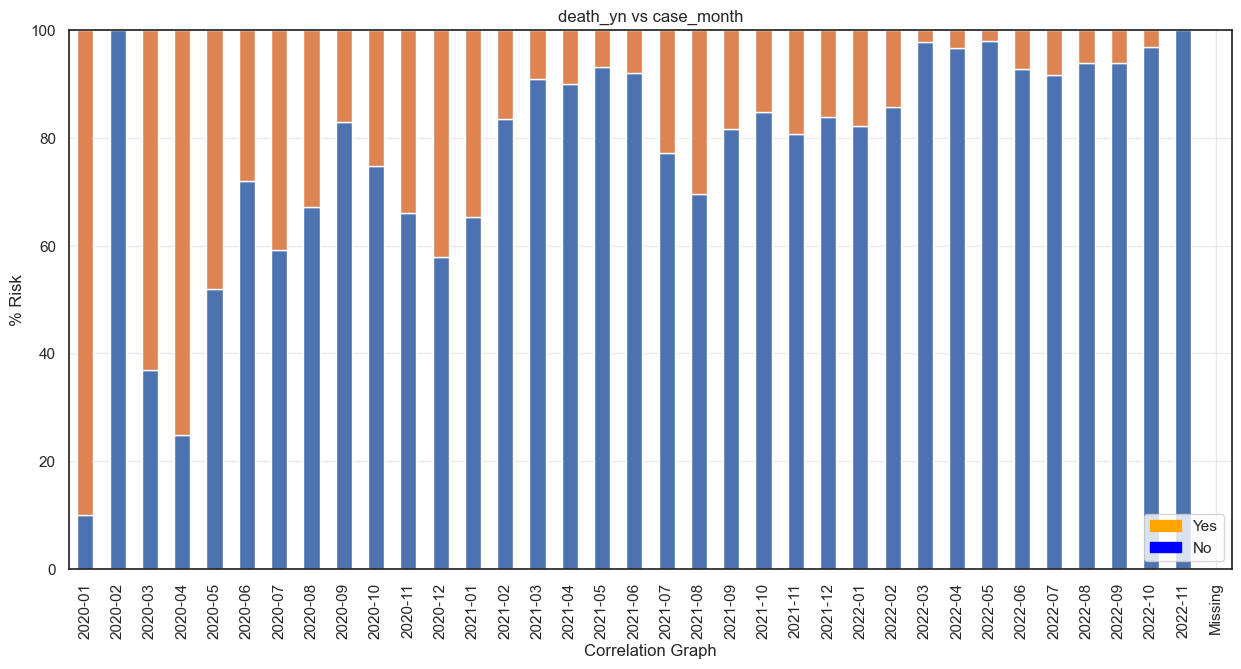

Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6741 ticks ([-0.4, ..., 1347.6]),

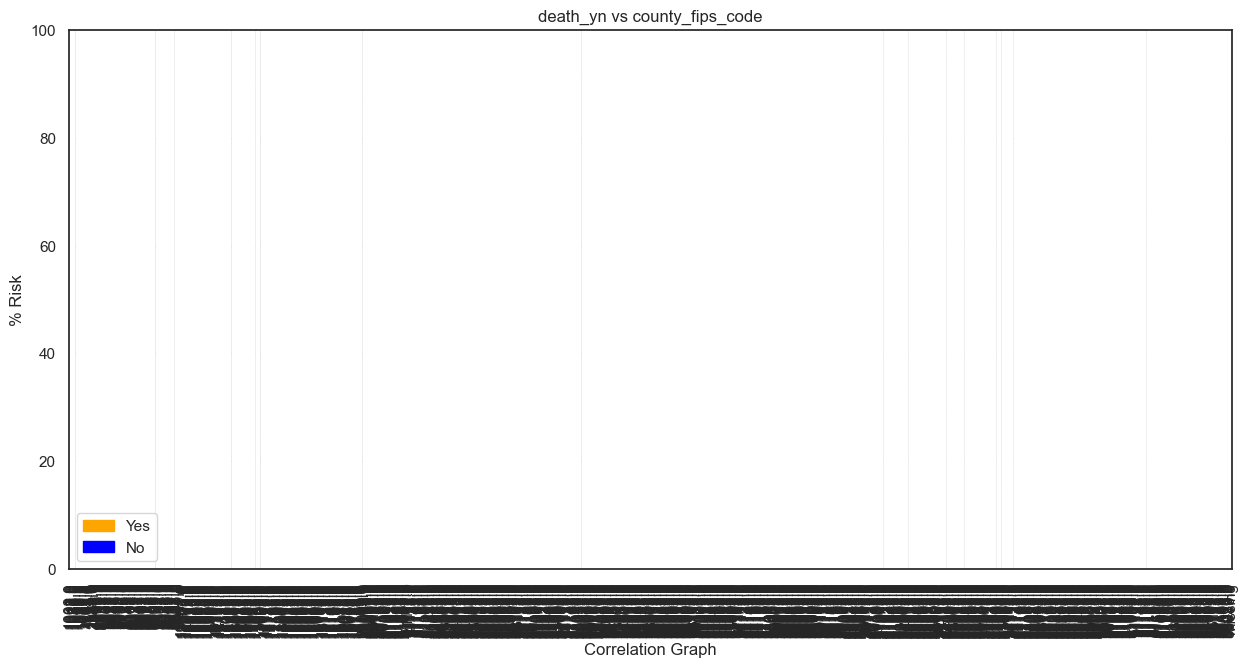

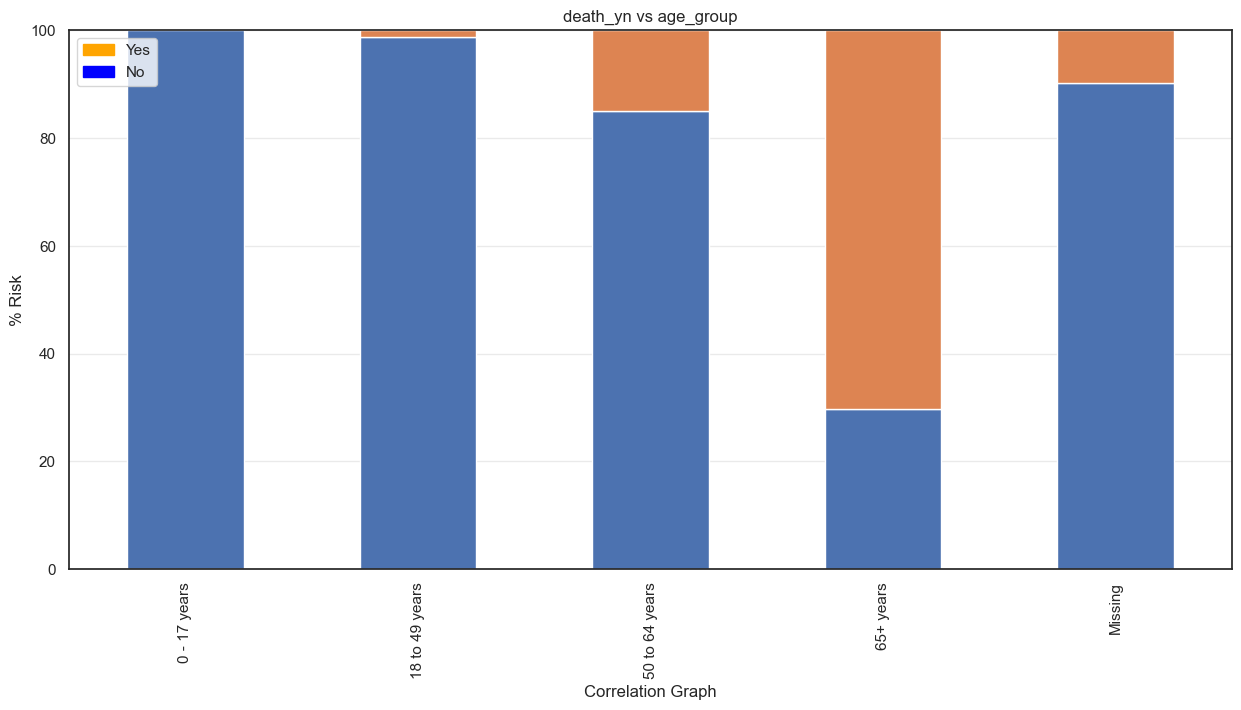

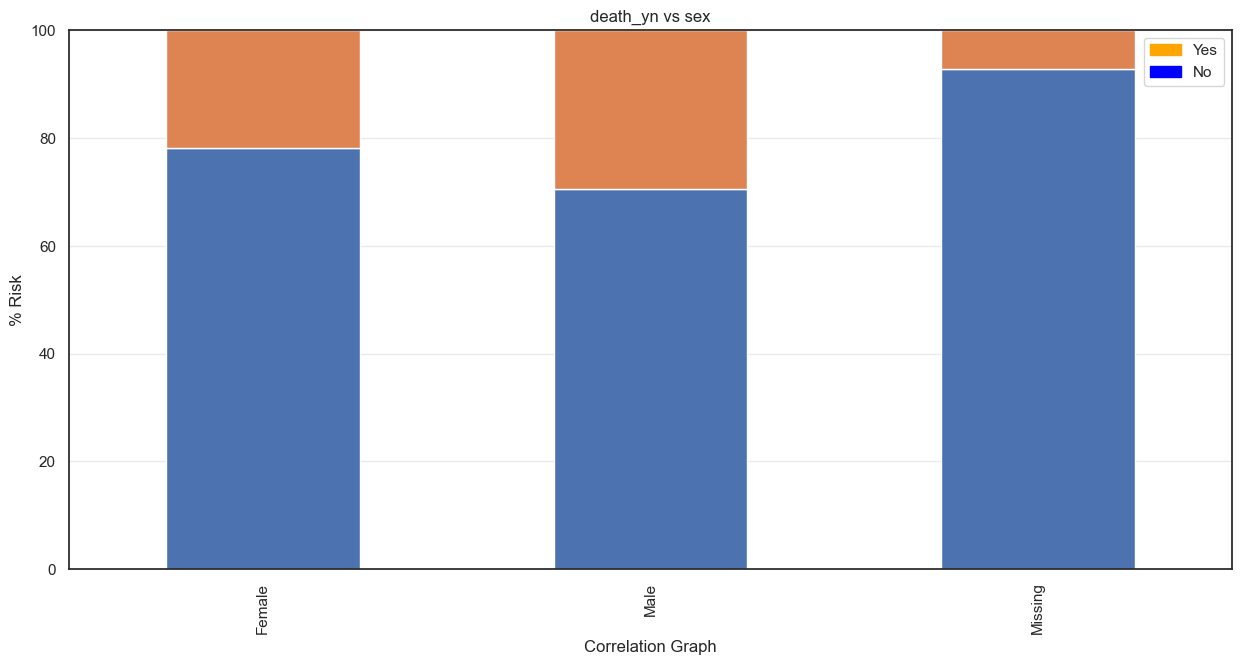

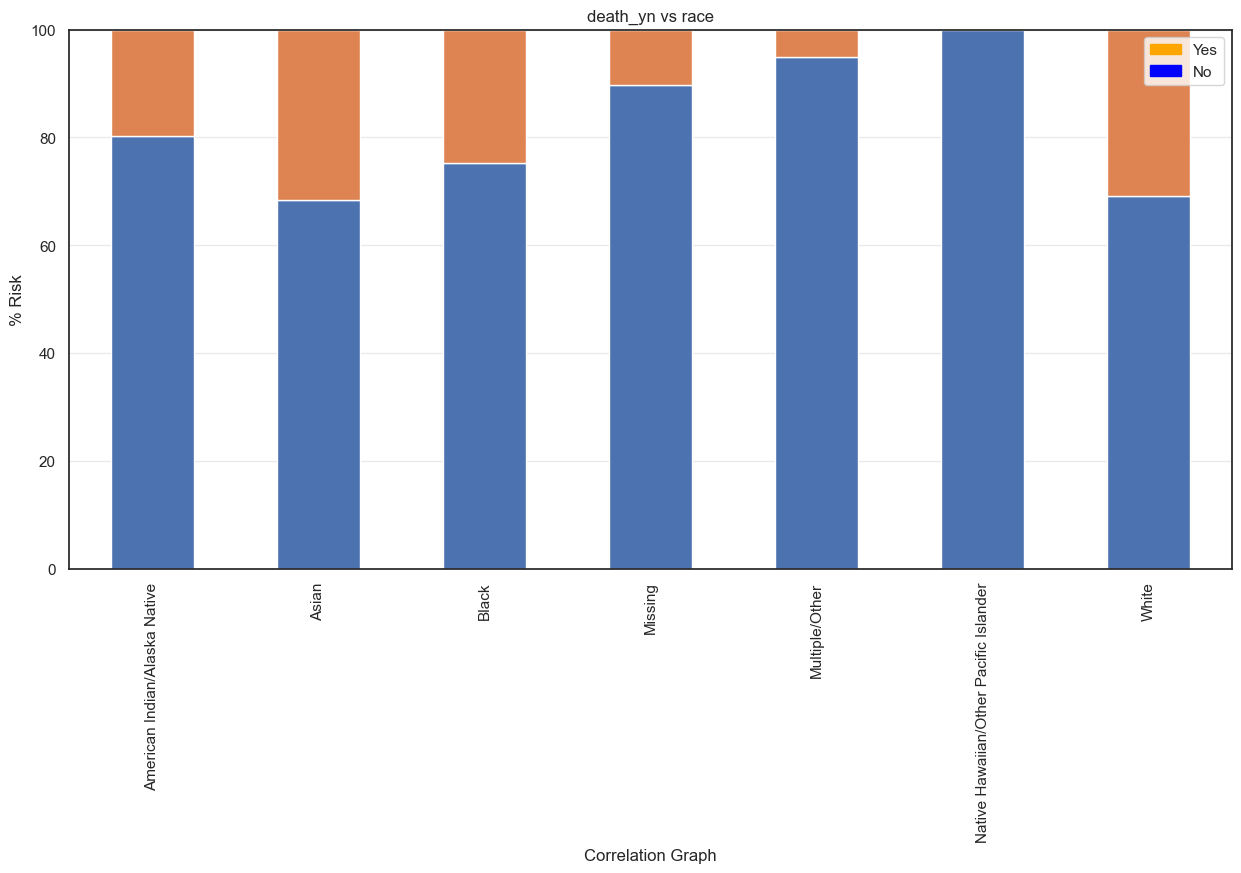

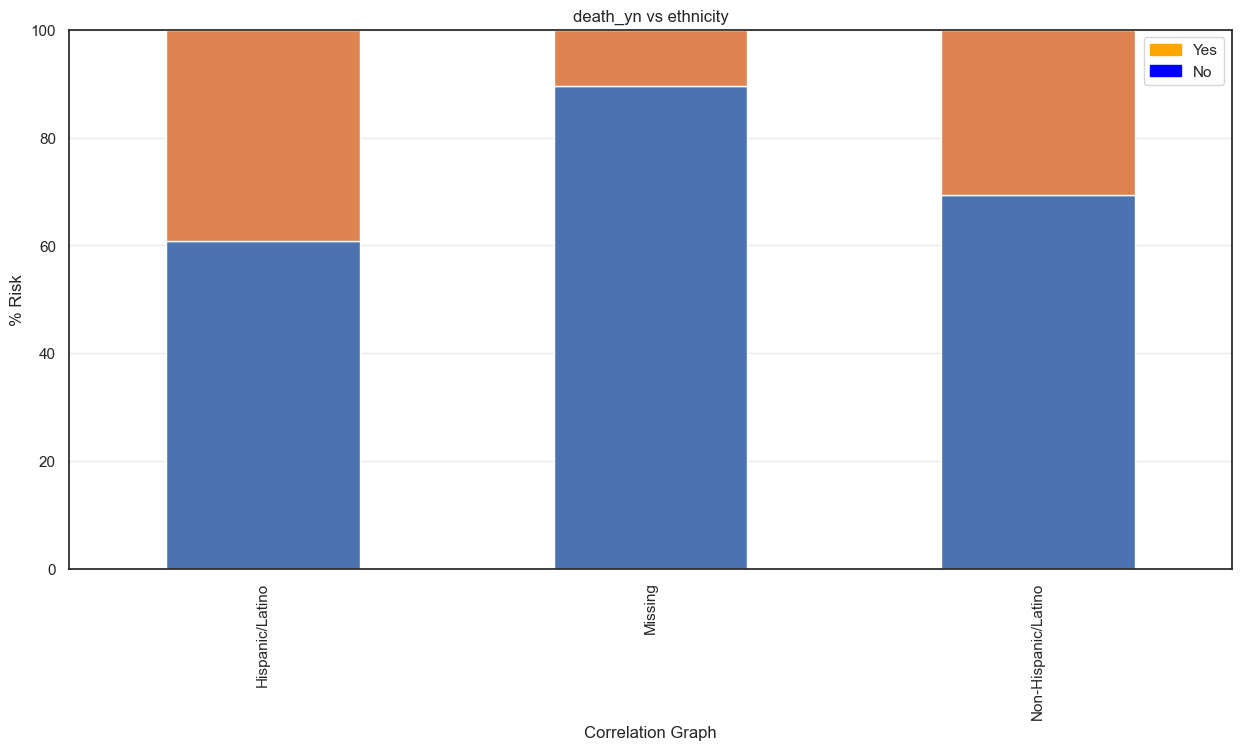

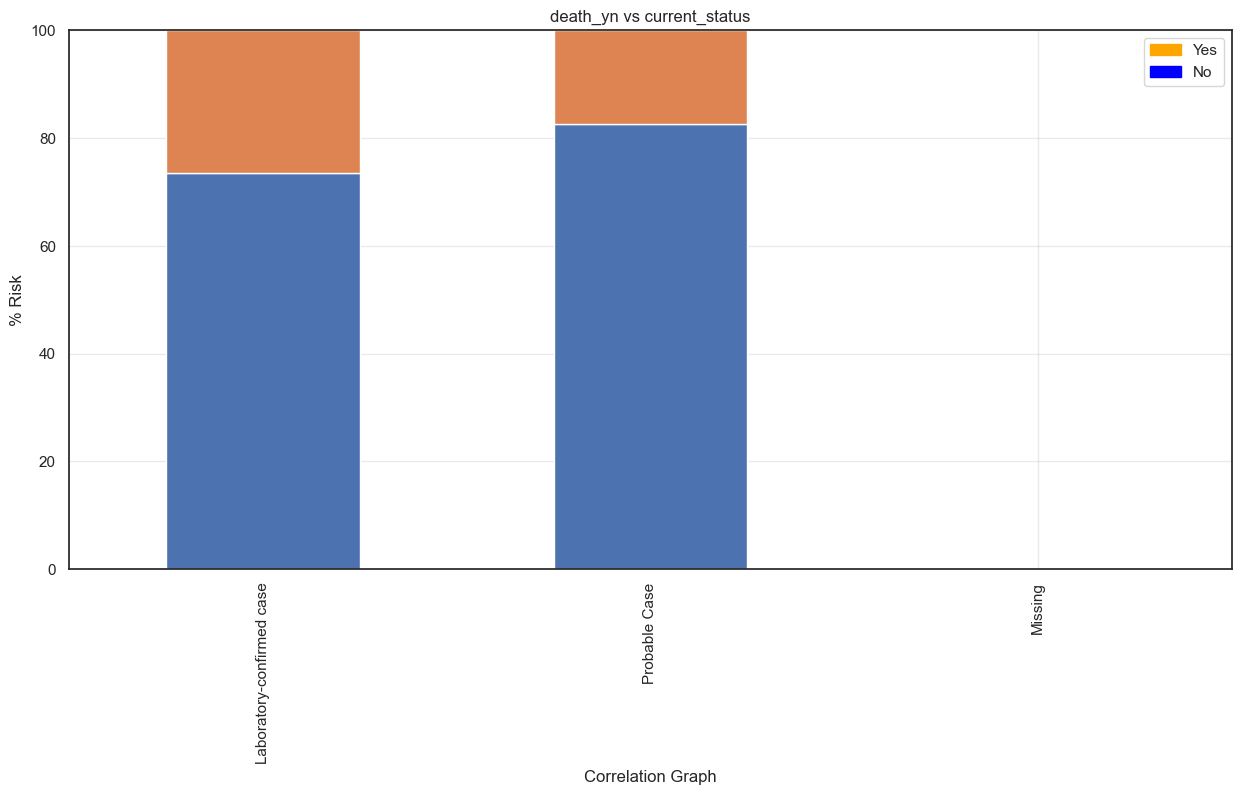

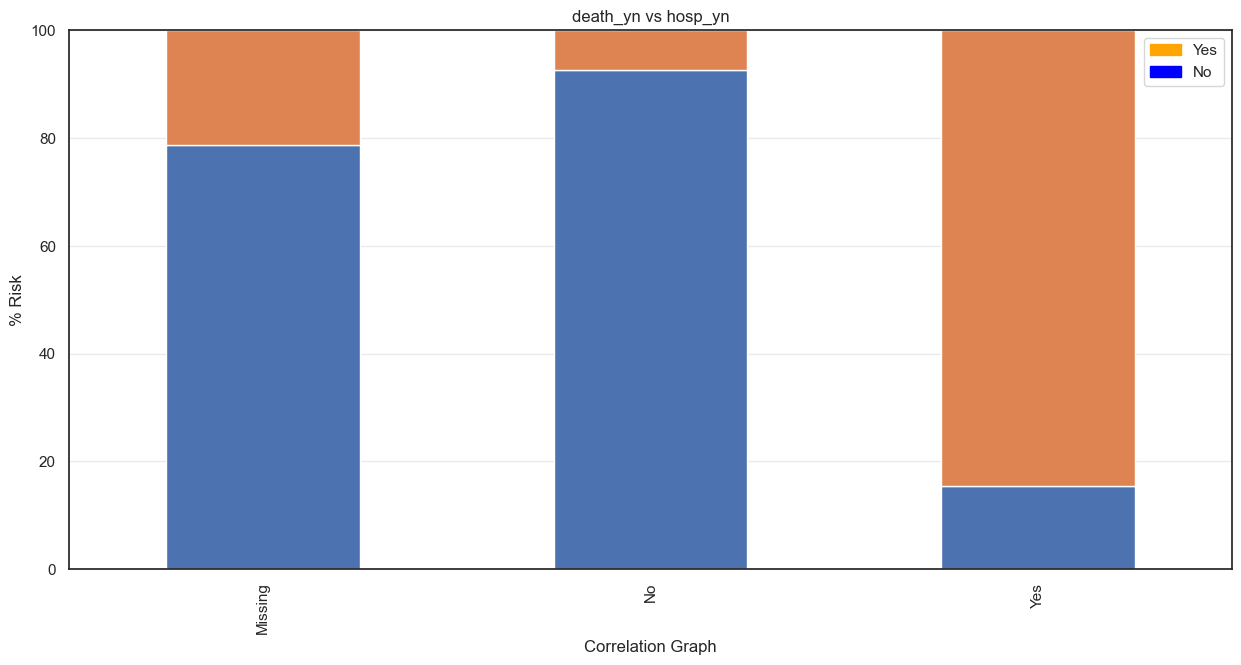

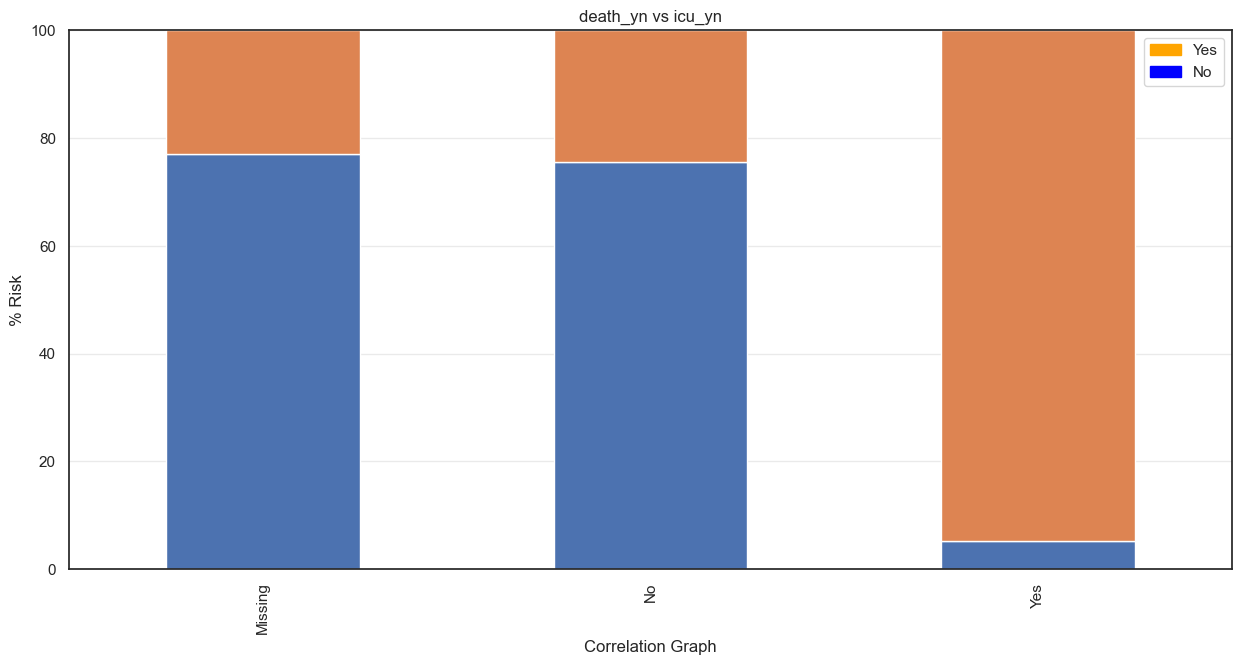

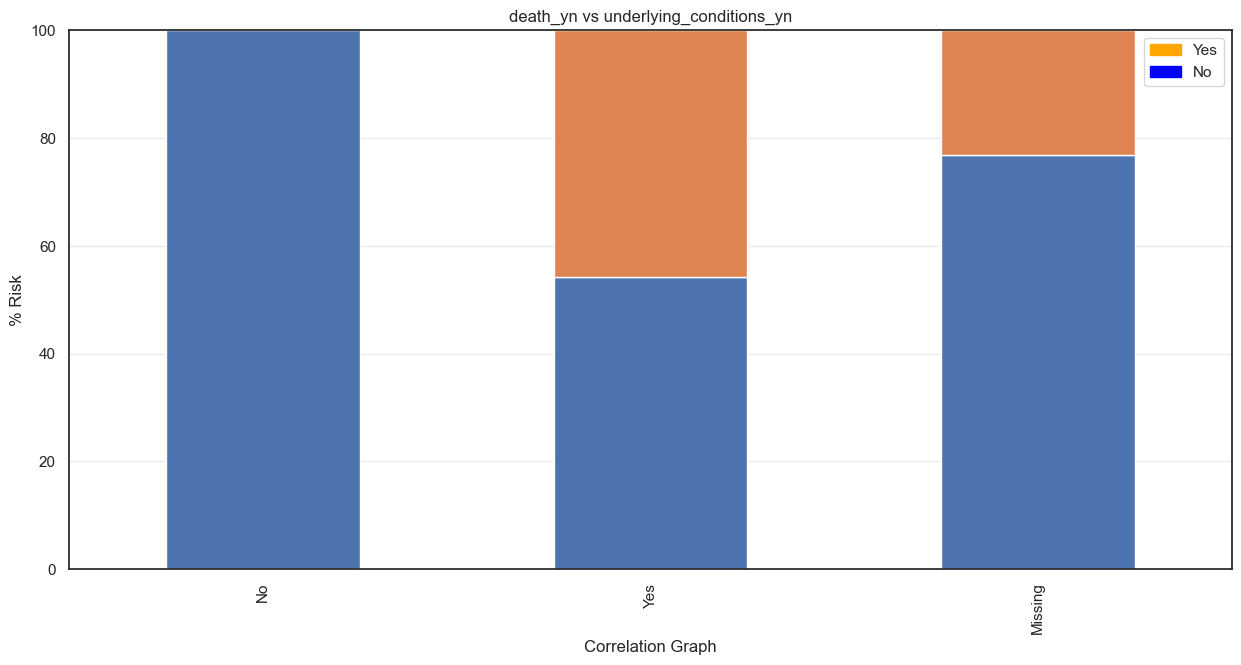

In [383]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)

categorical_columns = df[['case_month','county_fips_code','age_group','sex','race','ethnicity','current_status','hosp_yn','icu_yn','underlying_conditions_yn']].columns
# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_columns:
    
    maxDelqEver = pd.unique(df_temp[categorical_feature].ravel())

    # add new column and set values to zero
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")

    # for each delinquency category
    for i in maxDelqEver:

        count = df_temp[df_temp[categorical_feature] == i].count()['death_yn']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'death_yn']].groupby([categorical_feature,'death_yn']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"death_yn vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Yes')
    blue_patch = mpatches.Patch(color='blue', label='No')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines
    plt.grid(color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(color='#999999', linestyle='-', alpha=0.2)

    # add labels
    my_plot.set_xlabel("Correlation Graph")
    my_plot.set_ylabel("% Risk")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

# 1. Discussion of Correlations

### Comments on Correlations of Target, death_yn, to Each Feature

##### case_month
- Early cases in 2020 were much more likely to cause death, while as time went on the death rate steadily decreased, being almost 0 in the most recent month, November 2022.
- Some fluctuation can be seen in the winter months of each year (Oct - Jan), with the death rate being higher than in the warmer months.
- February 2020 shows an unusally high % no death for the tendency that can be observed in the graph around it. This might be due to faulty data as this outcome does not match the overall trend in the graph.

##### age_group
- A significant correlation can be seen in the ages of patients and their respective target outcome with age group 65+ years having a significantly higher death rate than all the others.
- Looking at the overall graph shape shows us that it is a gradual correlation wherein the older the patient is, the higher is the risk of death.
- This is a useful feature for predicting outcome as age groups are clearly correlated to the death outcome.

##### sex
- This feature shows little correlation with the target feature.
- It should be noted that even though the difference is not large, the Male category seems slightly more likely to result in death than the female one, however the missing values should not be disregarded and could alter this outcome if they were properly categorised into the two features that we have specific data for.

##### race
- Observing the stacked bar plot we can see some connections between race and our target feature, however when we look at the bar graph as well, we see that the total count of rows for each feature are very unevenly distributed across the dataset, and the % death value in our stacked graph can be misleading, given the data we are working with in this set.
- Given the limited dataset we are working with, these % death outcomes should be considered carefully.

##### ethnicity
- In this feature plot we see little connection between the three values and the target. The differences between thses outputs are not big when comparing to the other potentially more useful features.

##### current_status
- whether a case is laboratory confirmed or not seems to have very little effect on our target feature, with both options being from 75% to 85% death yes.

##### hosp_yn
- this feature clearly reveals that a person that was hospitalised was more likely to pass away. This is most likely due to the fact that they were suffering a more severe reaction to the virus than patients who did not need to be hospitalised at all.

##### icu_yn
- an extrememtly strong correlation is seen here where the value "yes" results in a 90% chance of death
- missing and no data also show some small connection to the target feature

##### underlying_conditions
- while the correlation is not 100%, we can clearly see that if a patient has underlying health conditions, they are at a roughly 50% risk of death
- patients with no underlying conditions on the other hand do not seem to be at risk

### Most Promising Subset
Given the above exploration of the features and their correlations to the target feature, the following features were chosen as a subset which is promising in terms of its ability to tell us something about the target outcome for a specific row:
- case_month: valuable
- age_group: extremely valuable
- hosp_yn: extremely valuable
- icu_yn: extremely valuable</ul>
### Features to Drop:
The following features did not provide useful information about the target feature and will therfore not be used for training the model
- county_fips_code
- current_status
- ethnicity
- race
- sex

In [384]:
low_information_gain = ['county_fips_code','current_status','ethnicity','race','sex']
high_information_gain = ['case_month','age_group','hosp_yn','icu_yn']

We will now drop these identified features from a copy of the original dataframe. This reduced dataset(df_rev1) can later be compared to the original(df).

In [385]:

df_rev1 = df.copy()
for col in low_information_gain:
    df_rev1.drop(col, axis=1, inplace=True)
print("\nRemaining columns:", df_rev1.columns)
print("\nNew shape:", df_rev1.shape)


Remaining columns: Index(['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'death_yn',
       'underlying_conditions_yn'],
      dtype='object')

New shape: (40000, 6)


# 1.3 Prepare dataset for modeling
- convert categorical features(all in this case) into dummies to allow modeling
- remove redundant dummies which contain no additional information
- set up train test split again based on the dataset with the dummies
### Set up dummy features
This changes the data type to "unit8"

In [386]:
df_rev1 = pd.get_dummies(df_rev1)
df_rev1.dtypes

death_yn                            float64
case_month_2020-01                    uint8
case_month_2020-02                    uint8
case_month_2020-03                    uint8
case_month_2020-04                    uint8
case_month_2020-05                    uint8
case_month_2020-06                    uint8
case_month_2020-07                    uint8
case_month_2020-08                    uint8
case_month_2020-09                    uint8
case_month_2020-10                    uint8
case_month_2020-11                    uint8
case_month_2020-12                    uint8
case_month_2021-01                    uint8
case_month_2021-02                    uint8
case_month_2021-03                    uint8
case_month_2021-04                    uint8
case_month_2021-05                    uint8
case_month_2021-06                    uint8
case_month_2021-07                    uint8
case_month_2021-08                    uint8
case_month_2021-09                    uint8
case_month_2021-10              

### Total Features are Categorical Columns:

In [387]:
categorical_columns = df_rev1.select_dtypes(include=['uint8']).columns.tolist()
features = categorical_columns
categorical_columns

['case_month_2020-01',
 'case_month_2020-02',
 'case_month_2020-03',
 'case_month_2020-04',
 'case_month_2020-05',
 'case_month_2020-06',
 'case_month_2020-07',
 'case_month_2020-08',
 'case_month_2020-09',
 'case_month_2020-10',
 'case_month_2020-11',
 'case_month_2020-12',
 'case_month_2021-01',
 'case_month_2021-02',
 'case_month_2021-03',
 'case_month_2021-04',
 'case_month_2021-05',
 'case_month_2021-06',
 'case_month_2021-07',
 'case_month_2021-08',
 'case_month_2021-09',
 'case_month_2021-10',
 'case_month_2021-11',
 'case_month_2021-12',
 'case_month_2022-01',
 'case_month_2022-02',
 'case_month_2022-03',
 'case_month_2022-04',
 'case_month_2022-05',
 'case_month_2022-06',
 'case_month_2022-07',
 'case_month_2022-08',
 'case_month_2022-09',
 'case_month_2022-10',
 'case_month_2022-11',
 'case_month_Missing',
 'age_group_0 - 17 years',
 'age_group_18 to 49 years',
 'age_group_50 to 64 years',
 'age_group_65+ years',
 'age_group_Missing',
 'hosp_yn_Missing',
 'hosp_yn_No',
 'hosp

### Setting up train/test split
- based on dataset with dummy values
- target stored in dataframe "y"
- remaining features in dataframe "X"
- both split into training and test subsets

In [388]:
# y is the target
y = df_rev1["death_yn"]
# X is everything else
X = df_rev1.drop(["death_yn"], axis=1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  40000
training range (70%):	 rows 0 to 28000
test range (30%): 	 rows 28000 to 40000


In [389]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
        case_month_2020-01  case_month_2020-02  case_month_2020-03  \
8224                    0                   0                   0   
11219                   0                   0                   0   
17353                   0                   0                   0   
15305                   0                   0                   0   
30147                   0                   0                   0   

       case_month_2020-04  case_month_2020-05  case_month_2020-06  \
8224                    0                   0                   0   
11219                   0                   0                   0   
17353                   0                   0                   0   
15305                   0                   0                   0   
30147                   0                   0                   0   

       case_month_2020-07  case_month_2020-08  case_month_2020-09  \
8224                    0                   0                   0   
112

### Reset the indices of the training and testing splits
- indexes are not consecutive at the moment. This needs to be dealt with as it will affect merging of dataframes later on.

In [390]:
X_train.head(5)

,case_month_2020-01,case_month_2020-02,case_month_2020-03,case_month_2020-04,case_month_2020-05,case_month_2020-06,case_month_2020-07,case_month_2020-08,case_month_2020-09,case_month_2020-10,...,age_group_Missing,hosp_yn_Missing,hosp_yn_No,hosp_yn_Yes,icu_yn_Missing,icu_yn_No,icu_yn_Yes,underlying_conditions_yn_No,underlying_conditions_yn_Yes,underlying_conditions_yn_Missing
8224,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
11219,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
17353,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
15305,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
30147,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [391]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,case_month_2020-01,case_month_2020-02,case_month_2020-03,case_month_2020-04,case_month_2020-05,case_month_2020-06,case_month_2020-07,case_month_2020-08,case_month_2020-09,case_month_2020-10,...,age_group_Missing,hosp_yn_Missing,hosp_yn_No,hosp_yn_Yes,icu_yn_Missing,icu_yn_No,icu_yn_Yes,underlying_conditions_yn_No,underlying_conditions_yn_Yes,underlying_conditions_yn_Missing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


# 2. Linear Regression Model
## 2.1 Train a Linear regression model using only the descriptive features selected above

In [392]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

## 2.2 Print out the coefficients learned by the model

In [393]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['case_month_2020-01', 'case_month_2020-02', 'case_month_2020-03',
       'case_month_2020-04', 'case_month_2020-05', 'case_month_2020-06',
       'case_month_2020-07', 'case_month_2020-08', 'case_month_2020-09',
       'case_month_2020-10', 'case_month_2020-11', 'case_month_2020-12',
       'case_month_2021-01', 'case_month_2021-02', 'case_month_2021-03',
       'case_month_2021-04', 'case_month_2021-05', 'case_month_2021-06',
       'case_month_2021-07', 'case_month_2021-08', 'case_month_2021-09',
       'case_month_2021-10', 'case_month_2021-11', 'case_month_2021-12',
       'case_month_2022-01', 'case_month_2022-02', 'case_month_2022-03',
       'case_month_2022-04', 'case_month_2022-05', 'case_month_2022-06',
       'case_month_2022-07', 'case_month_2022-08', 'case_month_2022-09',
       'case_month_2022-10', 'case_month_2022-11', 'case_month_Missing',
       'age_group_0 - 17 years', 'age_group_18 to 49 years',
       'age_group_50 to 64 years', 'age_group_

## 2.3 Interpreting the Linear Regression Model
- this model estimates the coefficients of a linear equation and models the relationship between a dependent variable(target feature) and any amount of independent variables(other features)
- To interpret it properly, the coefficients must be understood. The coefficient represents the change in the target feature for a one-unit change in the independent variable while keeping all other variables constant.
    - if the coefficient is positive, an increase in that variable will lead to an increase in the target feature's value too - a positive linear relationship
    - if the coefficient is negative, an increase in the independent variable leads to a decrease in the dependent variable - a negative linear relationship
- This model assumes a linear relationship between the target and other variables
- Outliers can influence the model as it may have trouble when capturing non-linear relationships
    - an outlier can have a huge impact on a model that works best with linear relationships. As the correlation is tied to a straight line any outlier has the capacity skew that line considerably, having an effect on the output that may be misleading.
<br>
- The Intercept is 352160384272.17316(w_0)
    - This is the predicted value of the target when all other independent variables = 0
    - where the model intercepts the y-axis
- About the coefficients for each feature
    - sum of feature*coefficent + intercept results in the model prediction
    - comparison is difficult as each value is directly tied to the range of values in the given feature</ul></ul>
### N.B. A Linear Regression model is not suited for a classification problem
- classification problems require specific categories of for example 1 or 0 as an output
- a linear regression model provides continuous data as a prediction, which cannot be used to accurately predict a feature whose values can only be 1 or 0, ie one class or another
- this can be dealt with by casting the output to within a range of the desired prediction by applying a threshold
    - eg. values >= 0.5 cast to 1, values <= 0.5 cast to 0</ul></ul>
##### A note on the Feature: case_month
This feature seems to be causing some issues for the model which can be seen in the values being negative and very large. This indicates that they may be incorrect or not properly scaled. Perhaps there is an issue with the preprocessing of the data before running the model which caused this not so useful result.


## 2.4 Printing 100 predicted target features and evaluating the prediction
- print predicted target value for the first 100 training examples
- apply threshold of 0.5 to get a predicted class for each example.
    - if value >= 0.5 predict 1, if value <= 0.5 predict 0

In [394]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_yn  Predicted
0        0.0        1.0
1        0.0        0.0
2        0.0        0.0
3        0.0        0.0
4        0.0        0.0
..       ...        ...
95       0.0        0.0
96       0.0        0.0
97       1.0        1.0
98       0.0        0.0
99       0.0        1.0

[100 rows x 2 columns]


## 2.5 Evaluation Metrics based on training data
- print classification evaluation measures: Accuracy, Confusion matrix, Precision, Recall, F1
- discuss the findings from these outputs

In [395]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.91975
Confusion matrix: 
 [[19662  1323]
 [  924  6091]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20985
         1.0       0.82      0.87      0.84      7015

    accuracy                           0.92     28000
   macro avg       0.89      0.90      0.90     28000
weighted avg       0.92      0.92      0.92     28000



## Interpretation of Results
##### Accuracy
The accuracy value of 0.91975 means that the model correctly classified 91.975% of its predictions in the training data.
##### Confusion Matrix
Counts of predictions in all rows:<br>
[0][0] TRUE NEGATIVE: correct prediction of 0 = 19,662<br>
[0][1] FALSE POSITIVE: false prediction of 1 = 1,323<br>
[1][0] FALSE NEGATIVE: false prediction of 0 = 1,924<br>
[1][1] TRUE POSITIVE: correct prediction of 1 = 6,091<br>
##### Precision
Class 0: correct 96% of the time.<br>
Class 1: correct 82% of the time.<br>
##### Recall
Class 0: correct indentification 94% of the time.<br>
Class 1: correct indentification 87% of the time<br>
##### F1 Score
Class 0: overall performance is 95%<br>
Class 1: overall performance is 84%<br>
### Summary
- Overall the model performs well for predicting the target feature with an accuracy of roughly 91%
- It has a sligtly better performance when predicting class 0 than class 1
- This makes sense as class 0 is much more common in the model than class 1 - these being death_no and death_yes respectively. In our dataset most of the patients did not die.
- This is not super useful as it would be more beneficial to predict a class 1 outcome if this model were to be used in a practical setting to decide medical treatment for example as it predicts more serious cases of illness less reliably

## 2.6 Evaluate the model using the test set (30% of original)
- compare results from test data to results from training data
- compare results from test data to results from a cross-validation model trained on the whole dataset

### Printing actual death_yn vs predicted based on test data

In [396]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_yn  Predicted
0        1.0        1.0
1        0.0        0.0
2        0.0        0.0
3        0.0        0.0
4        0.0        0.0
..       ...        ...
95       1.0        1.0
96       1.0        1.0
97       1.0        1.0
98       0.0        0.0
99       0.0        0.0

[100 rows x 2 columns]


### Evaluation metrics based on test data

In [397]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9194166666666667
Confusion matrix: 
 [[8424  591]
 [ 376 2609]]
Classification report - Test data:
                precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      9015
         1.0       0.82      0.87      0.84      2985

    accuracy                           0.92     12000
   macro avg       0.89      0.90      0.89     12000
weighted avg       0.92      0.92      0.92     12000


==================== Train Data ======================
Accuracy:  0.91975
Confusion matrix: 
 [[19662  1323]
 [  924  6091]]

Classification report: - Training data
                precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20985
         1.0       0.82      0.87      0.84      7015

    accuracy                           0.92     28000
   macro avg       0.89      0.90      0.90     28000
weighted avg       0.92      0.92      0.92     28000



## Interpretation of Test Results and comparision with Training Results from above
##### Accuracy
The accuracy is marginally lower on the test set than on the training set: 91.94% vs 91.97%
##### Confusion Matrix
Counts of predictions in all rows:<br>
[0][0] TRUE NEGATIVE: correct prediction of 0 = 8,424/12,000<br>
[0][1] FALSE POSITIVE: false prediction of 1 = 591/12,000<br>
[1][0] FALSE NEGATIVE: false prediction of 0 = 376/12,000<br>
[1][1] TRUE POSITIVE: correct prediction of 1 = 2609/12,000<br>
##### Precision
Class 0: stayed the same = 96% vs 96% <br>
Class 1: stayed the same = 82% vs 82% <br>
##### Recall
Class 0: slight reduction = 93% vs 94%<br>
Class 1: stayed the same = 87% vs 87%<br>
##### F1 Score
Class 0: stayed the same = 95% vs 95%<br>
Class 1: stayed the same = 84% vs 84%<br>
### Summary
- The output of the model is consistent with the training data when tested on the 30% split dataset
- This indicates that the model is performing well and could be used for making predictions on new data

## 2.7 Cross Validation
- same evaluation as above but multiple times
- each time the data is shuffled so we get a different view of the dataset to work with for both training and testing
- results are stored in a dictionary for later use</ul>
Create a function to perform cross validation(not provided by sklearn for linear regression specifically)

In [398]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

Create function to perform 10 fold cross validation and store results into dataframe.
- this is used to simplify further analysis as done before

In [399]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Use the functions to perform cross validation 10 fold and print out summary of results

In [400]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.918850
precision,0.813996
recall,0.874616
f1,0.843193


### Comments on results seen above
- These results are marginally lower than what we had seen before, which is to be expected. However they are not drastically different which is good.

# 3. Logistic Regression
## 3.1 Train a logistic regression model using the descriptive features chosen in part 1

In [401]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

## 3.2 Print the coefficients learned by the model

In [402]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['case_month_2020-01', 'case_month_2020-02', 'case_month_2020-03',
       'case_month_2020-04', 'case_month_2020-05', 'case_month_2020-06',
       'case_month_2020-07', 'case_month_2020-08', 'case_month_2020-09',
       'case_month_2020-10', 'case_month_2020-11', 'case_month_2020-12',
       'case_month_2021-01', 'case_month_2021-02', 'case_month_2021-03',
       'case_month_2021-04', 'case_month_2021-05', 'case_month_2021-06',
       'case_month_2021-07', 'case_month_2021-08', 'case_month_2021-09',
       'case_month_2021-10', 'case_month_2021-11', 'case_month_2021-12',
       'case_month_2022-01', 'case_month_2022-02', 'case_month_2022-03',
       'case_month_2022-04', 'case_month_2022-05', 'case_month_2022-06',
       'case_month_2022-07', 'case_month_2022-08', 'case_month_2022-09',
       'case_month_2022-10', 'case_month_2022-11', 'case_month_Missing',
       'age_group_0 - 17 years', 'age_group_18 to 49 years',
       'age_group_50 to 64 years', 'age_group_

## 3.3 Interpreting the Results
- This type of modeling is commonly used for binary classification problems, making it better suited to our problem than the linear regression model.
- the output is a probability rather than continuous data like the linear model
- The goal is to predict an even occuring, in our case the target feature death_yn has two events, yes and no
- the dependent variable, target feature, must be binary while all other variables can be either coninuous or categorical.
- Interpretation of coefficients is similar to how it is done in the linear regression model
    - each coefficient represents the log-odds of the target feature associated with a one-unit increase in the inidependent variable while holding all other variables constant
    - the sign of the coefficient, either + or -, shows the relationship between the independent variable and the event occurring.
        - a positive coefficient indicates that an increase in the variable is associated with a higher chance of the event occurring, ie. predicting 1
        - a negative coefficient is the opposite and indicates that a decrease in the variable is associated with a higher chance of the event occurring, ie. predicting 1</ul></ul></ul>
#### Example from above using feature icu_yn:
        - icu_yn_No has coefficient -1.049183241987524
        - icu_yn_Yes has coefficent 1.3507754377771608
        - These values show us the correlation present in this features connection with the target outcome. An increase of the coefficient, icu_yn_Yes, increases the chance of predicting death_yn_Yes, while the lower and negative coefficient of icu_yn_No shows a clear opposite effect on the outcome.

## 3.4 Printing 100 predicted target features and evaluating the prediction

In [403]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(100))


Predictions with multiple linear regression: 

    death_yn  Predicted
0        0.0        1.0
1        0.0        0.0
2        0.0        0.0
3        0.0        0.0
4        0.0        0.0
..       ...        ...
95       0.0        0.0
96       0.0        0.0
97       1.0        1.0
98       0.0        0.0
99       0.0        1.0

[100 rows x 2 columns]


## 3.5 Evaluation metrics based on training data
- print classification evaluation measures: Accuracy, Confusion matrix, Precision, Recall, F1
- discuss the findings from these outputs

In [404]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9204285714285714
Confusion matrix: 
 [[19795  1190]
 [ 1038  5977]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     20985
         1.0       0.83      0.85      0.84      7015

    accuracy                           0.92     28000
   macro avg       0.89      0.90      0.89     28000
weighted avg       0.92      0.92      0.92     28000



## Interpretation of Results
##### Accuracy
The accuracy value of 0.9204285... means that the model correctly classified 92.042% of its predictions in the training data.
##### Confusion Matrix
Counts of predictions in all rows:<br>
[0][0] TRUE NEGATIVE: correct prediction of 0 = 19,795<br>
[0][1] FALSE POSITIVE: false prediction of 1 = 1,190<br>
[1][0] FALSE NEGATIVE: false prediction of 0 = 1,038<br>
[1][1] TRUE POSITIVE: correct prediction of 1 = 5,977<br>
##### Precision
Class 0: correct 95% of the time.<br>
Class 1: correct 83% of the time.<br>
##### Recall
Class 0: correct indentification 94% of the time.<br>
Class 1: correct indentification 85% of the time<br>
##### F1 Score
Class 0: overall performance is 95%<br>
Class 1: overall performance is 84%<br>
### Summary
- Overall the model performs well for predicting the target feature with an accuracy of roughly 92%. This is 1% better than the linear regression model from part 2.
- Its prediction metrics are very much in line with the linear regression model
- The prediction precision for class 1 is a little better.

## 3.6 Evaluate the model using the test set (30% of original)
- compare results from test data to results from training data
- compare results from test data to results from a cross-validation model trained on the whole dataset

### Printing actual death_yn vs predicted based on test data

In [405]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death_yn  Predicted
0        1.0        1.0
1        0.0        0.0
2        0.0        0.0
3        0.0        0.0
4        0.0        0.0
5        1.0        1.0
6        0.0        0.0
7        0.0        0.0
8        0.0        0.0
9        0.0        0.0
10       0.0        0.0
11       0.0        0.0
12       0.0        0.0
13       1.0        1.0
14       1.0        0.0
15       0.0        0.0
16       1.0        1.0
17       0.0        0.0
18       0.0        0.0
19       0.0        0.0


### Evaluation based on test data

In [406]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.92275
Confusion matrix: 
 [[8506  509]
 [ 418 2567]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.95      0.94      0.95      9015
         1.0       0.83      0.86      0.85      2985

    accuracy                           0.92     12000
   macro avg       0.89      0.90      0.90     12000
weighted avg       0.92      0.92      0.92     12000

==================== Train Data =======================
Accuracy:  0.9204285714285714
Confusion matrix: 
 [[19795  1190]
 [ 1038  5977]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     20985
         1.0       0.83      0.85      0.84      7015

    accuracy                           0.92     28000
   macro avg       0.89      0.90      0.89     28000
weighted avg       0.92      0.92      0.92     28000



## Interpretation of Test Results and comparision with Training Results from above
##### Accuracy
The accuracy is marginally higher on the test set than on the training set: 92.275% vs 92.042%
##### Confusion Matrix
Counts of predictions in all rows:<br>
[0][0] TRUE NEGATIVE: correct prediction of 0 = 8,506/12,000<br>
[0][1] FALSE POSITIVE: false prediction of 1 = 509/12,000<br>
[1][0] FALSE NEGATIVE: false prediction of 0 = 418/12,000<br>
[1][1] TRUE POSITIVE: correct prediction of 1 = 2,567/12,000<br>
##### Precision
Class 0: stayed the same = 95% vs 95% <br>
Class 1: stayed the same = 83% vs 83% <br>
##### Recall
Class 0: stayed the same = 94% vs 94%<br>
Class 1: slightly higher = 86% vs 85%<br>
##### F1 Score
Class 0: stayed the same = 95% vs 95%<br>
Class 1: slightly higher = 85% vs 84%<br>
### Summary
- The output of the model is consistent with the training data when tested on the 30% split dataset
- This indicates that the model is performing well and could be used for making predictions on new data
- The accuracy has gone up surprisingly
- cross validation tests will be useful to fully interpret this model

## 3.7 Cross Validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [407]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [408]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.919975
precision,0.833004
recall,0.850600
f1,0.841579


### Comments on results seen above
These results show that the overall accuracy is just below 92% on average while it was just above in both the training and testing splits.<br>
Overall these results are in line with what we observed about this model earlier on.

# 4. Random Forest Model
## 4.1 Train a random forest model using only the descriptive features chosen in part 1
- train model on test data
- use RandomForestClassifier() function

In [409]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)

## 4.2 Understanding the Random Forest Model
- train decision trees and examine them individually to better understand the model as a whole
- This kind of model can be used both for regression as well as classification problems
- analysis of feature importance can help indentify the most polarising variables in the set
- analysing individual trees can show up biases or patterns that may be present and affecting the result
- A random forest model can be prone to overfitting, making it less useful when predicting on new data that it was not tested on - ie. poor generalisation. This can be examined and dealt with by using cross-validation or stopping the model at a certain depth</ul>
### 4.2.1 Train Decision Tree
- train 2 decision trees with the same test data:
    - one with max_depth=4 and the other with max_depth=10
    - these different depths will limit the tree to a certain point at which it needs to stop and provide and answer

In [410]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=10, random_state=1)


### 4.2.2 Display the Decision Trees for analysis
Create a graph of each tree and store as image

In [411]:
import graphviz
from graphviz import Source

# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

#### Examining Tree with max_depth=4
- The root is age_group_65+years, a highly valuable feature and value pair from the original set for indicating the outcome of the target feature.
- for each split the model picks the best feature which when combined with the previously chosen one/s will provided better prediction of the target

<img src="DecisionTree4.png">

#### Examining Tree with max_depth=10
- the tree quickly becomes more complicated
- a Random forest model has 100 of trees like this by default
- each tree gets a slightly different view of the data, allowing for exhaustive and useful examination.

<img src="DecisionTree10.png">

### 4.2.3 Interpretation of the random forest model
The model helps us keep track of the most valuable features in predicting out target as they are chosen as the root. The dataframe below shows us how the model ranked the importance of the features
- this ranking will help us in our optimisation going forward
    - what are the best features to keep
    - what features can be dropped without major consequences of losing information

In [412]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
39,age_group_65+ years,3.276243e-01
43,hosp_yn_Yes,2.262626e-01
37,age_group_18 to 49 years,1.055783e-01
42,hosp_yn_No,7.002858e-02
36,age_group_0 - 17 years,3.555772e-02
41,hosp_yn_Missing,2.851453e-02
3,case_month_2020-04,2.803737e-02
46,icu_yn_Yes,2.760851e-02
38,age_group_50 to 64 years,2.536534e-02
11,case_month_2020-12,9.270433e-03


## 4.4 Printing 100 predicted target features and evaluating the prediction

In [413]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0.0,1.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
95,0.0,0.0
96,0.0,0.0
97,1.0,1.0
98,0.0,0.0


## 4.5 Evaluation metrics based on training data
- print classification evaluation measures: Accuracy, Confusion matrix, Precision, Recall, F1
- discuss the findings from these outputs

In [414]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9276785714285715
Confusion matrix: 
 [[19790  1195]
 [  830  6185]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20985
         1.0       0.84      0.88      0.86      7015

    accuracy                           0.93     28000
   macro avg       0.90      0.91      0.91     28000
weighted avg       0.93      0.93      0.93     28000



## Interpretation of Results
##### Accuracy
The accuracy value of 0.927678... means that the model correctly classified 92.767% of its predictions in the training data.
##### Confusion Matrix
Counts of predictions in all rows:<br>
[0][0] TRUE NEGATIVE: correct prediction of 0 = 19,790<br>
[0][1] FALSE POSITIVE: false prediction of 1 = 1,195<br>
[1][0] FALSE NEGATIVE: false prediction of 0 = 830<br>
[1][1] TRUE POSITIVE: correct prediction of 1 = 6,185<br>
##### Precision
Class 0: correct 96% of the time.<br>
Class 1: correct 84% of the time.<br>
##### Recall
Class 0: correct indentification 94% of the time.<br>
Class 1: correct indentification 88% of the time<br>
##### F1 Score
Class 0: overall performance is 95%<br>
Class 1: overall performance is 86%<br>
### Summary
- Overall the model performs well for predicting the target feature with an accuracy of roughly 92%.
- Its prediction metrics are very much in line with both the linear regression model and the logistic model
- The prediction precision for class 1 is a little better than both of the previous models

## 4.6 Evaluate the model using the testing data, 30%
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data

In [415]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,1.0,1.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


Evaluation metrics from test data:

In [416]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.92375
Confusion matrix: 
 [[8473  542]
 [ 373 2612]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      9015
         1.0       0.83      0.88      0.85      2985

    accuracy                           0.92     12000
   macro avg       0.89      0.91      0.90     12000
weighted avg       0.93      0.92      0.92     12000

==================== Train Data =======================
Accuracy:  0.9276785714285715
Confusion matrix: 
 [[19790  1195]
 [  830  6185]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20985
         1.0       0.84      0.88      0.86      7015

    accuracy                           0.93     28000
   macro avg       0.90      0.91      0.91     28000
weighted avg       0.93      0.93      0.93     28000



### Summary
- Overall the model performs well for predicting the target feature with an accuracy of roughly 92%.
- The model is consistent with the other models trained in predicting the target feature.

## 4.7 Cross Validation
- perform cross validation and store results in dictionary for later use

In [417]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

### Summary of resulst for Random Forest Model
This takes about 1.5 minutes.

In [418]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.922675
precision,0.827164
recall,0.873200
f1,0.849527


The accuracy is the same as before. Overall the model is in line with the others.

## 4.8 Out of Bag Accuracy
- should be in line with cross validation results but is generally expected to be a little lower

In [419]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9223928571428571

This result is very much in line with the cross validation results you can see above.

# 5. Improving Predictive Models
## 5.1 Which model of the ones trained performed better at predicting the target feature?
- All models performed nearly the same on the datasets provided, around +/- 1% change
- the summary of resulst can be seen in the dataframe below based on predicting a good outcome of death_yn_No
- these results are a subset of the original features from the dataset as we dropped the less significant ones back in part 1. This will be examined further in part 5.3

In [420]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.918850,0.919975,0.922675
precision,0.813996,0.833004,0.827164
recall,0.874616,0.850600,0.873200
f1,0.843193,0.841579,0.849527


## 5.2 Is the model more accurate than a simple model that always predicts the majority class
- compare model results to a majority prediction
</ul>
Break down dataset and compute majority class.

In [421]:
good_count = y_test[y_test == 1].count()
bad_count = y_test[y_test == 0].count()
total = good_count+ bad_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number death_yn_Yes:\t {good_count}\t{round(good_count/len(y_test)*100,2)}%')
print(f'Total number death_yn_No:\t {bad_count}\t{round(bad_count/len(y_test)*100,2)}%')

From original dataset: 		Count 12000
Total number death_yn_Yes:	 2985	24.88%
Total number death_yn_No:	 9015	75.12%


##### We can see that the majority class is No by a rather large margin.
We will now generate scores for predicting the majority class

In [422]:
# generate array of 253 zeros (length of test dataset)
majority = np.zeros(12000)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("==================== Majority Prediction =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))
print("================================================================")

==================== Majority Prediction =======================
Accuracy:  0.75125
Confusion matrix: 
 [[9015    0]
 [2985    0]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      9015
         1.0       0.00      0.00      0.00      2985

    accuracy                           0.75     12000
   macro avg       0.38      0.50      0.43     12000
weighted avg       0.56      0.75      0.64     12000



### Examination of Results
The majority prediction performs much worse than all of the trained models with an accuracy of only 75.125% compared to the average of 92% from the models.
- for predicting class 0, death_yn_No, the model is much better than at predicting class 1, death_yn_Yes
- This way of predicting is incapable of predicting class 1, the minority class

## 5.3 Compare Model performance using different feature subsets
### 5.3.1 All features
- repeat tests using all features
- set up dataframe using the original features

In [423]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)
# set X,y
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  1414


With the dataframe set up we will generate results based on these features
- This operation is simplified as we have set up functions in part 2,3,4 to allow cross validated scores to be returned in dataframes 

### calculate Linear regression, logistic regression, random forest results again using all features

In [425]:
# Most recent runtime: 6 minutes
linRegDF = cross_val_LinReg_DF(X,y)

In [426]:
# Most recent runtime: 2 minutes
logRegDF = cross_val_LogReg_DF(X,y)

In [427]:
# Most recent runtime: 15 minutes
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.938750,0.945875,0.939675
precision,0.888037,0.892248,0.868532
recall,0.863379,0.891300,0.894200
f1,0.875511,0.891691,0.881123


The results above show that overall the Logistic Regression model performs the best out of the three, but only by a margin of roughly 1%.

### 5.3.2 High Correlation Features only
- repeat the same test as above using only the high correlation features identified in part 1
- again we set up a dataframe to use

In [428]:
high_information_gain

['case_month', 'age_group', 'hosp_yn', 'icu_yn']

In [429]:
df_highCorr = pd.get_dummies(df)
y = df_highCorr["death_yn"]
X = df_highCorr[X_train.columns]
print("Number of features: ", len(X.columns))

Number of features:  50


In [430]:
# most recent runtime: 2 minutes
# calculate Linear regression, logistic regression, random forest results again
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_HighCorrFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_HighCorrFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.918850,0.919975,0.922675
precision,0.813996,0.833004,0.827164
recall,0.874616,0.850600,0.873200
f1,0.843193,0.841579,0.849527


### 5.3.3 Comparison of feature set so far

In [431]:
print("\nScores using all features: 19 features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: ")
print("===================================================================")
print(ResultsDF)
print("\nScores using high Correlation features only: 4 features")
print("===================================================================")
print(ResultsDF_HighCorrFeatures)


Scores using all features: 19 features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.938750             0.945875        0.939675
precision           0.888037             0.892248        0.868532
recall              0.863379             0.891300        0.894200
f1                  0.875511             0.891691        0.881123

Scores using subset of features: 
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.918850             0.919975        0.922675
precision           0.813996             0.833004        0.827164
recall              0.874616             0.850600        0.873200
f1                  0.843193             0.841579        0.849527

Scores using high Correlation features only: 4 features
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.918850             0.919975        0.922675
precision           0.813996             0.833004      

From the above results it is clear that using all features actually has a beneficial effect on the different models, increasing the overall performance accuracy by about 2%, and the f1 by about 5%. 
- When using more features the best model is Logistic Regression
- In the highly correlated feature set, the Random Forest model performs best.

## 5.4 Further Optimisations
##### Altering Features Used
- the models might improve by using derived features
    - the case_month feature, despite being valuable, contains many different values when compared to the other highly correlated features that were chosen in part 1. This feature could produce a derived feature of either month or season.
- the selection of highly valuable features could be re-examined, especially for the Random Forest Model.
    - features which do not have the very best correlation could be added to the training of the model to give it more choices when establishing trees and choosing valuable features to make decisions based on
- other domain knowledge might be used to creat new features to add to the model
    - the locations, race and ethnicity of the patients were disregarded in the model above, however if they were contained in a new feature like income this might tell us something more about the target feature, like perhaps seeing the effect on the target feature for people who are more likely to have access to healthcare vs those who are not. The income feature could be generated by using average incomes in locations, combined with any racial biases that are known and documented online.
- for the linear regression model, encoding the data using One Hot encoding may improve performance and produce more interpretable coefficients</ul></ul>
##### Altering Calculations Performed
- editing the depth of the random forest model
    - changing the max_depth of the model to see the effect it has on the predictive output

## 5.4.1 Re-Evaluating the high-correlation features used
- derive feature "season" from case_month  and get rid of case_month with its many unique values

### Creating the season feature derived from case_month and examining the results

In [432]:
df['case_month']

0        2020-03
1        2020-12
2        2020-12
3        2021-02
4        2021-12
          ...   
39995    2021-01
39996    2021-08
39997    2021-02
39998    2022-05
39999    2021-07
Name: case_month, Length: 40000, dtype: category
Categories (36, object): ['2020-01', '2020-02', '2020-03', '2020-04', ..., '2022-09', '2022-10', '2022-11', 'Missing']

In [433]:
# Convert the "case_month" column to a datetime type
df['case_month'] = pd.to_datetime(df['case_month'])

# Define a function to map each month to its corresponding season
def get_season(month):
    if month.month in (11, 12, 1):
        return 'winter'
    elif month.month in (2, 3, 4):
        return 'spring'
    elif month.month in (5, 6, 7):
        return 'summer'
    elif month.month in (8, 9, 10):
        return 'autumn'
    else:
        return None

# Create a new "season" column by applying the "get_season" function to the "case_month" column
df['season'] = df['case_month'].apply(get_season)

In [434]:
df.dtypes

case_month                  datetime64[ns]
county_fips_code                  category
age_group                         category
sex                               category
race                              category
ethnicity                         category
current_status                    category
hosp_yn                           category
icu_yn                            category
death_yn                           float64
underlying_conditions_yn          category
season                              object
dtype: object

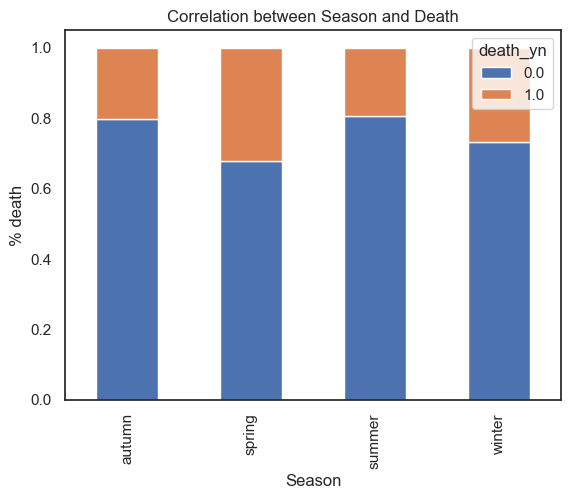

In [435]:
# Compute the counts and percentages of "death_yn" for each "season"
counts = pd.crosstab(df['season'], df['death_yn'])
percentages = counts.div(counts.sum(axis=1), axis=0)

# Create a stacked bar graph of the percentages
ax = percentages.plot.bar(stacked=True)

# Add axis labels and a title
ax.set_xlabel('Season')
ax.set_ylabel('% death')
ax.set_title('Correlation between Season and Death')

# Display the plot
plt.show()

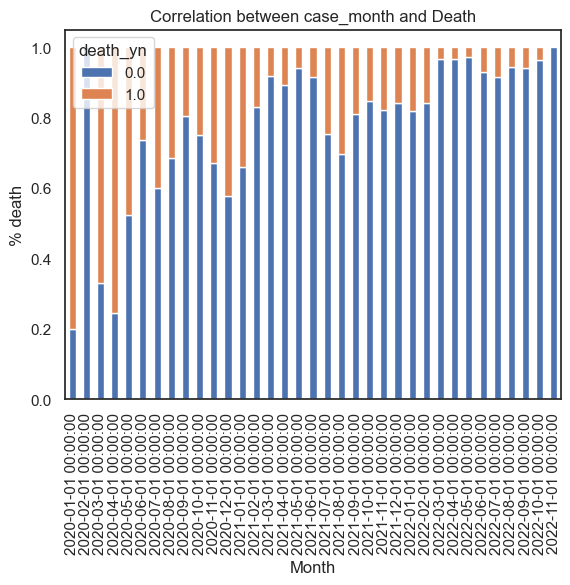

In [436]:
# Compute the counts and percentages of "death_yn" for each "season"
counts = pd.crosstab(df['case_month'], df['death_yn'])
percentages = counts.div(counts.sum(axis=1), axis=0)

# Create a stacked bar graph of the percentages
ax = percentages.plot.bar(stacked=True)

# Add axis labels and a title
ax.set_xlabel('Month')
ax.set_ylabel('% death')
ax.set_title('Correlation between case_month and Death')

# Display the plot
plt.show()

### Examination of Correlation Graphs
The above graphs show that despite the hypothesis that seasons might be correlated to death rate, this does not seem to be the case. The correlations are weak as seen in the plot of Season vs Death.
<br>
- another potential feature might be year, as the plot of all case_months agains Death show a decline in death rates over time</ul>
### Creating a year feature derived from case_month

In [437]:
# Create a new "year" column by extracting the year component from the "case_month" column
df['year'] = df['case_month'].dt.year

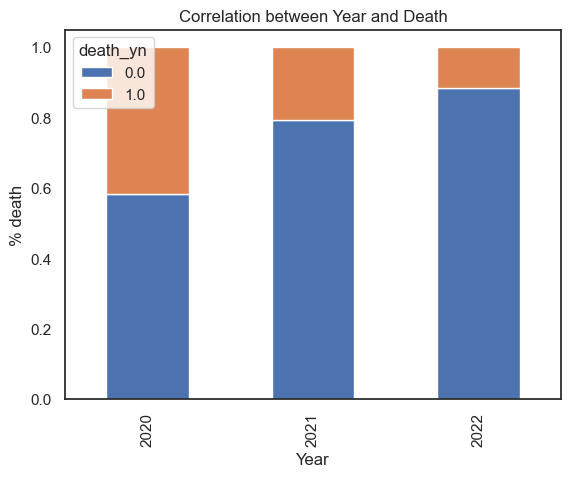

In [438]:
# Compute the counts and percentages of "death_yn" for each "season"
counts = pd.crosstab(df['year'], df['death_yn'])
percentages = counts.div(counts.sum(axis=1), axis=0)

# Create a stacked bar graph of the percentages
ax = percentages.plot.bar(stacked=True)

# Add axis labels and a title
ax.set_xlabel('Year')
ax.set_ylabel('% death')
ax.set_title('Correlation between Year and Death')

# Display the plot
plt.show()

### Examination of Correlation Graphs
This new feature seems more promising than the previously created season feature. There is a correlation between year and death with more deaths occurring in 2020 and less as the years went on. I will keep this feature for further training of the models and drop the seasons one again as it was not of much use.
- change data type of year to categorical
- drop season and case_month features

In [439]:
df['year'] = df['year'].astype('category')
df.dtypes

case_month                  datetime64[ns]
county_fips_code                  category
age_group                         category
sex                               category
race                              category
ethnicity                         category
current_status                    category
hosp_yn                           category
icu_yn                            category
death_yn                           float64
underlying_conditions_yn          category
season                              object
year                              category
dtype: object

In [440]:
low_correlation_features = ['case_month', 'season']
df = df.drop(low_correlation_features, axis=1)
df.dtypes

county_fips_code            category
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                     float64
underlying_conditions_yn    category
year                        category
dtype: object

In [441]:
df1 = pd.read_csv('covid19-cdc-unclean-concat.csv')
res_state = df1['res_state']

In [442]:
res_state.unique()

array(['LA', 'CT', 'OK', 'NY', 'OH', 'PA', 'MO', 'IL', 'CA', 'AZ', 'MD',
       'WI', 'TX', 'MS', 'NJ', 'MI', 'FL', 'UT', 'TN', 'MN', 'NC', 'IN',
       'AR', 'MA', 'KY', 'VA', 'WA', 'SC', 'OR', 'KS', 'DC', 'IA', 'GA',
       'NM', 'CO', 'PR', 'NV', 'MT', 'ID', 'AL', 'WY', 'ND', 'NH', 'RI',
       'ME', 'VT', 'AK', 'VI', 'GU'], dtype=object)

### 5.4.1.1 Adding the Income Feature
I got domain information online to be able to add an income feature to the dataset, in order to see if this had any bearing on the target feature.
<br>
Data obtained here: https://www.visualcapitalist.com/interactive-median-income-u-s-counties/

In [443]:
income_df = pd.read_csv('Median_Income_by_State_and_County.csv', encoding='utf-16-le', delimiter='\t')
income_df.dtypes

State                        object
County                       object
Overflow Data Description    object
Estimate                      int64
dtype: object

In [444]:
income_df.head(5)

,State,County,Overflow Data Description,Estimate
0,Oklahoma,Blaine County,Median Household Income ($),41972
1,Oklahoma,Bryan County,Median Household Income ($),38847
2,Oklahoma,Caddo County,Median Household Income ($),40674
3,Oklahoma,Canadian County,Median Household Income ($),64505
4,Oklahoma,Carter County,Median Household Income ($),44531


### The state names must be mapped to the two-letter codes used in our own dataset in order to use the income data from the external source.

In [445]:
# Create a DataFrame with the two-letter state codes and their corresponding full state names
state_names = pd.DataFrame({
    'code': ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN',
             'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV',
             'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN',
             'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'],
    'state': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
              'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
              'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
              'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
              'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
              'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
              'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
              'Wisconsin', 'Wyoming']
})

In [446]:
# Merge the two DataFrames based on the "res_state" column
df1 = df1.merge(state_names, left_on='res_state', right_on='code', how='left')
df1 = df1.drop(['code'], axis=1)
df1.columns

Index(['case_month', 'res_state', 'state_fips_code', 'res_county',
       'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity',
       'case_positive_specimen_interval', 'case_onset_interval', 'process',
       'exposure_yn', 'current_status', 'symptom_status', 'hosp_yn', 'icu_yn',
       'death_yn', 'underlying_conditions_yn', 'state'],
      dtype='object')

In [447]:
df1['res_state'].unique()

array(['LA', 'CT', 'OK', 'NY', 'OH', 'PA', 'MO', 'IL', 'CA', 'AZ', 'MD',
       'WI', 'TX', 'MS', 'NJ', 'MI', 'FL', 'UT', 'TN', 'MN', 'NC', 'IN',
       'AR', 'MA', 'KY', 'VA', 'WA', 'SC', 'OR', 'KS', 'DC', 'IA', 'GA',
       'NM', 'CO', 'PR', 'NV', 'MT', 'ID', 'AL', 'WY', 'ND', 'NH', 'RI',
       'ME', 'VT', 'AK', 'VI', 'GU'], dtype=object)

In [448]:
df1['state'].unique()

array(['Louisiana', 'Connecticut', 'Oklahoma', 'New York', 'Ohio',
       'Pennsylvania', 'Missouri', 'Illinois', 'California', 'Arizona',
       'Maryland', 'Wisconsin', 'Texas', 'Mississippi', 'New Jersey',
       'Michigan', 'Florida', 'Utah', 'Tennessee', 'Minnesota',
       'North Carolina', 'Indiana', 'Arkansas', 'Massachusetts',
       'Kentucky', 'Virginia', 'Washington', 'South Carolina', 'Oregon',
       'Kansas', nan, 'Iowa', 'Georgia', 'New Mexico', 'Colorado',
       'Nevada', 'Montana', 'Idaho', 'Alabama', 'Wyoming', 'North Dakota',
       'New Hampshire', 'Rhode Island', 'Maine', 'Vermont', 'Alaska'],
      dtype=object)

In [449]:
state_mean_income = income_df.groupby('State')['Estimate'].mean()

state_income_df = pd.DataFrame({'State': state_mean_income.index, 'state_mean_income':state_mean_income.values})

income_df = pd.merge(income_df, state_income_df, on='State')
income_df.head(5)

,State,County,Overflow Data Description,Estimate,state_mean_income
0,Oklahoma,Blaine County,Median Household Income ($),41972,44097.376623
1,Oklahoma,Bryan County,Median Household Income ($),38847,44097.376623
2,Oklahoma,Caddo County,Median Household Income ($),40674,44097.376623
3,Oklahoma,Canadian County,Median Household Income ($),64505,44097.376623
4,Oklahoma,Carter County,Median Household Income ($),44531,44097.376623


In [450]:
df2 = pd.merge(df1, state_income_df, left_on='state', right_on='State')
df2 = df2.drop(columns='State')

In [451]:
df2.head(5)

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,...,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,state,state_mean_income
0,2020-03,LA,22.0,ORLEANS,22071.0,65+ years,Female,Black,Non-Hispanic/Latino,0.0,...,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Yes,NaN,Louisiana,41411.78125
1,2020-12,LA,22.0,CADDO,22017.0,65+ years,Female,Black,Non-Hispanic/Latino,0.0,...,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Yes,NaN,Louisiana,41411.78125
2,2021-01,LA,22.0,ST. TAMMANY,22103.0,65+ years,Male,White,Non-Hispanic/Latino,0.0,...,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Yes,NaN,Louisiana,41411.78125
3,2021-07,LA,22.0,ST. TAMMANY,22103.0,65+ years,Male,White,Non-Hispanic/Latino,0.0,...,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Yes,NaN,Louisiana,41411.78125
4,2020-03,LA,22.0,ORLEANS,22071.0,65+ years,Male,Black,Non-Hispanic/Latino,0.0,...,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Unknown,Yes,NaN,Louisiana,41411.78125


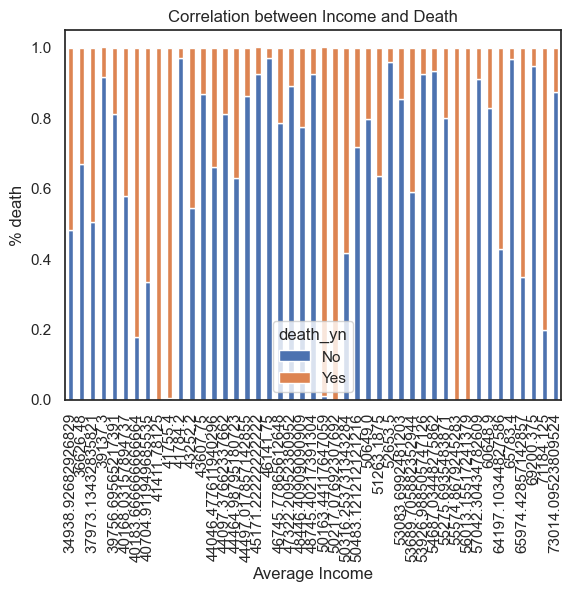

In [452]:
# Compute the counts and percentages of "death_yn" for each "season"
counts = pd.crosstab(df2['state_mean_income'], df2['death_yn'])
percentages = counts.div(counts.sum(axis=1), axis=0)

# Create a stacked bar graph of the percentages
ax = percentages.plot.bar(stacked=True)

# Add axis labels and a title
ax.set_xlabel('Average Income')
ax.set_ylabel('% death')
ax.set_title('Correlation between Income and Death')

# Display the plot
plt.show()

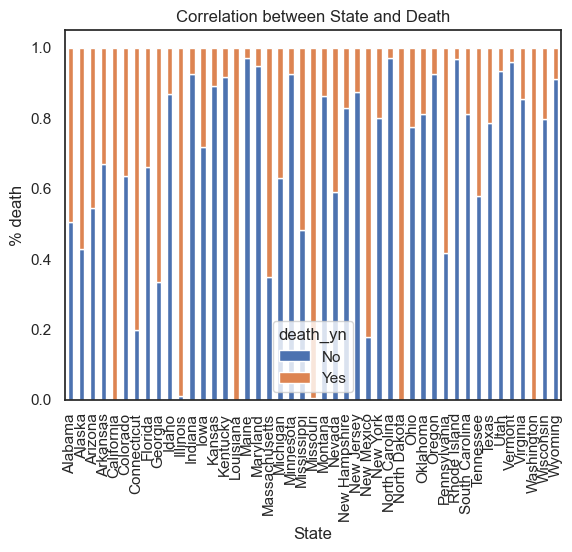

In [453]:
# Compute the counts and percentages of "death_yn" for each "season"
counts = pd.crosstab(df2['state'], df2['death_yn'])
percentages = counts.div(counts.sum(axis=1), axis=0)

# Create a stacked bar graph of the percentages
ax = percentages.plot.bar(stacked=True)

# Add axis labels and a title
ax.set_xlabel('State')
ax.set_ylabel('% death')
ax.set_title('Correlation between State and Death')

# Display the plot
plt.show()

### Comments on the new features proposed
##### year
This feature will be added to the dataframe for training. It may provide some information about our target
##### income
This feature does not show any promising correlations as we had hoped. It will not be used.
## 5.4.2 Re-training models given the research just completed
- drop income feature
- prep dataset as in Part 1
- use year feature in place of case_month feature for the different modles and examine the results

In [454]:
df2.dtypes

case_month                          object
res_state                           object
state_fips_code                    float64
res_county                          object
county_fips_code                   float64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
process                             object
exposure_yn                         object
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
state                               object
state_mean_income                  float64
dtype: object

Adding the year feature to df2

In [455]:
df2['case_month'] = pd.to_datetime(df2['case_month'])
df2['year'] = df2['case_month'].dt.year

Dropping all features identified in part 1 to have little correlation with the target feature.

In [456]:
df2 = df2.drop(['case_month','res_state','state_fips_code','res_county','county_fips_code','race','ethnicity','case_positive_specimen_interval','process','state_mean_income','state','exposure_yn','symptom_status','case_onset_interval',], axis=1)
df2.head(1)

,age_group,sex,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year
0,65+ years,Female,Laboratory-confirmed case,Unknown,Unknown,Yes,NaN,2020


In [457]:
df2['year'] = df2['year'].astype('object')
df2.dtypes

age_group                   object
sex                         object
current_status              object
hosp_yn                     object
icu_yn                      object
death_yn                    object
underlying_conditions_yn    object
year                        object
dtype: object

In [458]:
for col in df2.columns:
    df2[col] = df2[col].astype('category')
df2.dtypes

age_group                   category
sex                         category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                    category
underlying_conditions_yn    category
year                        category
dtype: object

Dealing with Unknown and NaN values as before.

In [459]:
cols_to_replace = ['age_group','current_status','hosp_yn','icu_yn','underlying_conditions_yn','year']
df2[cols_to_replace] = df2[cols_to_replace].replace({'Unknown': 'Missing', 'NaN':'Missing'})
df2['age_group'].head(1)

0    65+ years
Name: age_group, dtype: category
Categories (5, object): ['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years', 'Missing']

In [460]:
category_columns = df2.select_dtypes(["object"]).columns

for col in category_columns:
    df2[col] = df2[col].astype('category')
df2.dtypes

age_group                   category
sex                         category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                    category
underlying_conditions_yn    category
year                        category
dtype: object

In [461]:
for col in df2.columns:
    if "Missing" not in df2[col].cat.categories:
        df2[col] = df2[col].cat.add_categories("Missing")
    df2[col] = df2[col].fillna("Missing")

In [462]:
#map death_yn into boolean
df2['death_yn'] = df2['death_yn'].map({'Yes':1, "No":0})

In [463]:
#suffle dataset
df2.set_index(np.random.permutation(df2.index))
df2.sort_index(inplace=True)
df2.head(5)

,age_group,sex,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year
0,65+ years,Female,Laboratory-confirmed case,Missing,Missing,1.0,Missing,2020
1,65+ years,Female,Laboratory-confirmed case,Missing,Missing,1.0,Missing,2020
2,65+ years,Male,Laboratory-confirmed case,Missing,Missing,1.0,Missing,2021
3,65+ years,Male,Laboratory-confirmed case,Missing,Missing,1.0,Missing,2021
4,65+ years,Male,Laboratory-confirmed case,Missing,Missing,1.0,Missing,2020


In [464]:
y = pd.DataFrame(df2['death_yn'])
X = df2.drop(['death_yn'], axis=1)

In [465]:
#split dataset into 70/30 training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("original range is: ",df2.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  39733
training range (70%):	 rows 0 to 27813
test range (30%): 	 rows 27813 to 39733


### Features to keep and drop were decided in part 1. In addition we will use year instead of case_month

In [466]:
low_information_gain = ['current_status','sex','underlying_conditions_yn']
high_information_gain = ['year','age_group','hosp_yn','icu_yn']

In [467]:
df_rev2 = df2.copy()
for col in low_information_gain:
    df_rev2.drop(col, axis=1, inplace=True)
print("\nRemaining columns:", df_rev2.columns)
print("\nNew shape:", df_rev2.shape)


Remaining columns: Index(['age_group', 'hosp_yn', 'icu_yn', 'death_yn', 'year'], dtype='object')

New shape: (39733, 5)


In [468]:
df_rev2 = pd.get_dummies(df_rev2)
df_rev2.dtypes

death_yn                    float64
age_group_0 - 17 years        uint8
age_group_18 to 49 years      uint8
age_group_50 to 64 years      uint8
age_group_65+ years           uint8
age_group_Missing             uint8
hosp_yn_Missing               uint8
hosp_yn_No                    uint8
hosp_yn_Yes                   uint8
icu_yn_Missing                uint8
icu_yn_No                     uint8
icu_yn_Yes                    uint8
year_2020                     uint8
year_2021                     uint8
year_2022                     uint8
year_Missing                  uint8
dtype: object

In [469]:
categorical_columns = df_rev2.select_dtypes(include=['uint8']).columns.tolist()
features = categorical_columns
categorical_columns

['age_group_0 - 17 years',
 'age_group_18 to 49 years',
 'age_group_50 to 64 years',
 'age_group_65+ years',
 'age_group_Missing',
 'hosp_yn_Missing',
 'hosp_yn_No',
 'hosp_yn_Yes',
 'icu_yn_Missing',
 'icu_yn_No',
 'icu_yn_Yes',
 'year_2020',
 'year_2021',
 'year_2022',
 'year_Missing']

Setting up the train test split 70/30

In [470]:
# y is the target
y = df_rev2["death_yn"]
# X is everything else
X = df_rev2.drop(["death_yn"], axis=1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev2.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  39733
training range (70%):	 rows 0 to 27813
test range (30%): 	 rows 27813 to 39733


In [471]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
        age_group_0 - 17 years  age_group_18 to 49 years  \
4249                        0                         1   
13060                       0                         1   
38640                       0                         0   
13023                       0                         0   
32045                       0                         0   

       age_group_50 to 64 years  age_group_65+ years  age_group_Missing  \
4249                          0                    0                  0   
13060                         0                    0                  0   
38640                         0                    1                  0   
13023                         0                    1                  0   
32045                         0                    1                  0   

       hosp_yn_Missing  hosp_yn_No  hosp_yn_Yes  icu_yn_Missing  icu_yn_No  \
4249                 0           1            0               1          0   
13060    

In [472]:
X_train.head(5)

,age_group_0 - 17 years,age_group_18 to 49 years,age_group_50 to 64 years,age_group_65+ years,age_group_Missing,hosp_yn_Missing,hosp_yn_No,hosp_yn_Yes,icu_yn_Missing,icu_yn_No,icu_yn_Yes,year_2020,year_2021,year_2022,year_Missing
4249,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
13060,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
38640,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0
13023,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0
32045,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0


In [473]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,age_group_0 - 17 years,age_group_18 to 49 years,age_group_50 to 64 years,age_group_65+ years,age_group_Missing,hosp_yn_Missing,hosp_yn_No,hosp_yn_Yes,icu_yn_Missing,icu_yn_No,icu_yn_Yes,year_2020,year_2021,year_2022,year_Missing
0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0
3,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0


## Training Linear, Logistic and Random Forest Models and comparing results

In [474]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

In [475]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['age_group_0 - 17 years', 'age_group_18 to 49 years',
       'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing',
       'hosp_yn_Missing', 'hosp_yn_No', 'hosp_yn_Yes', 'icu_yn_Missing',
       'icu_yn_No', 'icu_yn_Yes', 'year_2020', 'year_2021', 'year_2022',
       'year_Missing'],
      dtype='object')

Coeficients are: 
 [ 2.64064833 -0.02778904  1.43991494  2.27684652  0.99272639  0.6554252
  1.38026373  0.98148333  0.49522537  0.32728821  1.13547352  1.22814551
  0.97107165 -0.27935944 -0.58898655 -0.07514066 -0.8096967  -0.34558634
  0.97929991  1.31096579  0.37338822 -0.13081429  0.39041341  0.24285667
  0.30167015 -0.15190325 -1.98271608 -1.78926917 -2.12096039 -1.02131155
 -1.21406334 -1.3467773  -1.55941321 -2.28845723 -2.47963828  0.
 -3.51749467 -1.37342368  0.82671753  3.54041825  0.4350066  -0.23255005
 -1.52529298  1.66906706 -0.39036816 -1.04918324  1.35077544 -0.42610221
  0.12701897  0.21030728]

Intercept is: 
 [-2.87228131]

In [476]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.916233
precision,0.830513
recall,0.834120
f1,0.832022


In [477]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

In [478]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['age_group_0 - 17 years', 'age_group_18 to 49 years',
       'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing',
       'hosp_yn_Missing', 'hosp_yn_No', 'hosp_yn_Yes', 'icu_yn_Missing',
       'icu_yn_No', 'icu_yn_Yes', 'year_2020', 'year_2021', 'year_2022',
       'year_Missing'],
      dtype='object')

Coeficients are: 
 [-3.54896185 -1.44973904  0.8247848   3.4582764   0.71711604 -0.20525128
 -1.50814863  1.71487626 -0.39726499 -1.11659994  1.51534128  0.83172644
  0.10625424 -0.93650432  0.        ]

Intercept is: 
 [-2.23522316]

Features and coeficients: 
 [('age_group_0 - 17 years', -3.5489618491952313), ('age_group_18 to 49 years', -1.449739041872187), ('age_group_50 to 64 years', 0.8247848040143134), ('age_group_65+ years', 3.4582763972514536), ('age_group_Missing', 0.717116041845391), ('hosp_yn_Missing', -0.2052512776421115), ('hosp_yn_No', -1.5081486318394892), ('hosp_yn_Yes', 1.7148762615256508), ('icu_yn_Missing', -0.397264986754

In [479]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.915410
precision,0.828883
recall,0.832301
f1,0.829812


In [480]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)

In [481]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
3,age_group_65+ years,0.400484
7,hosp_yn_Yes,0.177675
6,hosp_yn_No,0.108247
1,age_group_18 to 49 years,0.103759
5,hosp_yn_Missing,0.041757
0,age_group_0 - 17 years,0.038642
11,year_2020,0.033052
13,year_2022,0.027261
2,age_group_50 to 64 years,0.024596
10,icu_yn_Yes,0.023744


In [482]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.917247
precision,0.824336
recall,0.849696
f1,0.836014


In [483]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.916233,0.915410,0.917247
precision,0.830513,0.828883,0.824336
recall,0.834120,0.832301,0.849696
f1,0.832022,0.829812,0.836014


### Summary of results from using year instead of case_month
Overall the effect on the predictive abilities of the three models is not that big. The average accuracy is still at roughly 91%, a drop of 1% from the average on the dataframe containing the case_month feature instead. This alteration may not be worth it for this particular dataset.

### 5.4.2 Optimise Max Depth
#### Most recent runtime: 9 minutes

In [484]:
# setup dataframe
df_all = pd.get_dummies(df2)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)

# initialised empty daraframe
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in range(1,11):
    df2 = cross_val_RandomForest_DF(X,y,i)
    df2.rename(columns={'Random_Forests':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df2], axis=1)

# same calculation but use no max depth this time
no_max_depth = cross_val_RandomForest_DF(X,y)
no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,no_max_depth
accuracy,0.777716,0.870159,0.896055,0.907079,0.910099,0.916316,0.917373,0.918002,0.915838,0.916115,0.915511
precision,0.850315,0.911894,0.898471,0.869334,0.860927,0.825307,0.825244,0.826499,0.820427,0.824014,0.823444
recall,0.115403,0.530802,0.658429,0.740856,0.764321,0.843324,0.848887,0.849697,0.849190,0.844333,0.842208
f1,0.192917,0.667338,0.757078,0.797677,0.807901,0.833344,0.836096,0.837242,0.833654,0.833221,0.831858


The optimal depth for this model seems to be at max_depth=6. At this depth the model achieves:
- Accuracy ~91.63%
- Precision ~82.53%
- Recall ~84.33%
- F1 ~83.33%</ul>
These values are high when compared to the other depths, and beyond depth 7 the improvement is minimal while the models complexity is increasing. These higher depths are therefore not needed for this model to perform its best and limiting the model to a max_depth of 6 will reduce computational costs.

### 5.4.2 Optimise Number of Estimators

In [485]:
# setup dataframe
# df_all = pd.get_dummies(df)
# y = df_all["death_yn"]
# X = df_all.drop(["death_yn"],1)

# initialised empty daraframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for item in n_estimators:
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=100,estimators=200
accuracy,0.913698,0.914630,0.915938,0.915234,0.915108,0.915737,0.915536,0.915511,0.915813
precision,0.821861,0.822248,0.822015,0.821716,0.819990,0.822928,0.823214,0.823444,0.823608
recall,0.835434,0.839681,0.846663,0.843728,0.845952,0.844030,0.842512,0.842208,0.843523
f1,0.827721,0.829986,0.833292,0.831687,0.831911,0.832571,0.831976,0.831858,0.832630


As the number of estimators increases, so does the quality of predictions made by the model. However, overall the increase from one estimator to 200 is not that large. It may be possible to use this model with the lower number of estimators and reduce computing costs, while still having a reliable prediction output.

### 5.4.2 Optimise Number of Features
#### Most recent runtime: 4 minutes

In [486]:
# setup dataframe
# df_all = pd.get_dummies(df2)
# y = df_all["death_yn"]
# X = df_all.drop(["death_yn"],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)

# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature',1, inplace=True)
importance

,importance
feature,
age_group_65+ years,0.383676
hosp_yn_Yes,0.192165
age_group_18 to 49 years,0.102895
hosp_yn_No,0.098651
year_2020,0.038761
hosp_yn_Missing,0.032617
age_group_0 - 17 years,0.029834
age_group_50 to 64 years,0.025898
year_2022,0.025767


# NB. The following calculation takes considerable time
### Most recent runtime: 14 minutes

In [487]:
df_all = pd.get_dummies(df)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)

# set up empty list to store features
list_features = []

# set up empty dataframe to store results
RandomForest_Features = pd.DataFrame()
count=0

# loop over 'importance' dataframe adding 1 feature per loop (will be the next most important feature)
# each loop calculates the score for the current number of features in the list_features
# Each loop appends result to RandomForest_Features dataframe
for index, row in importance.iterrows():
    # only calculate the top 20 features to keep runtime down
    if count < 20:
        list_features.append(index)
        X = df_all[list_features]
        df1 = cross_val_RandomForest_DF(X,y, depth=6)
        df1.rename(columns={'Random_Forests':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=1
    else:
        break

# to display all columns    
#pd.set_option('display.max_columns', 40)
RandomForest_Features  

,features=1,features=2,features=3,features=4,features=5,features=6,features=7,features=8,features=9,features=10,features=11,features=12,features=13,features=14,features=15,features=16,features=17,features=18,features=19,features=20
accuracy,0.876625,0.881025,0.885400,0.904325,0.910400,0.910400,0.911775,0.911725,0.917275,0.917875,0.917750,0.918000,0.917650,0.918425,0.918050,0.918575,0.919050,0.918700,0.918325,0.918575
precision,0.701994,0.687735,0.700203,0.803930,0.776765,0.776765,0.780447,0.780411,0.821388,0.821424,0.821210,0.827355,0.824142,0.824579,0.828073,0.828126,0.827723,0.829531,0.828083,0.828243
recall,0.880300,0.960300,0.947400,0.816500,0.900500,0.900500,0.900500,0.900300,0.855100,0.858100,0.857800,0.849300,0.852600,0.855800,0.848400,0.851000,0.854000,0.849400,0.849800,0.850800
f1,0.781076,0.801452,0.805233,0.810111,0.834049,0.834049,0.836171,0.836065,0.837868,0.839330,0.839075,0.838143,0.838079,0.839863,0.838077,0.839362,0.840621,0.839299,0.838749,0.839326


Here we can see that adding more features to the trees helps up to a certain point. At 10 features the improvement is negligible, increasing only by 0.0007.
- it is noteworthy that a single feature already gives an accuracy of 87.66%. This is very high.
- the features identified in part 1 as highly correlated are proven to be so here, with the age group of 65+ being the most valuable indicator so much so that decent predictions could be made based only on that.

## 5.5 Summary and Conclusion
In this notebook we examined and evaluated three different predictive models. Here are the main observations taken:
- all three models perform almost the same
- many features do not have much value in predicting the target outcome
- the optimisations undertaken show little improvement in each of the models abilities and are therefore not a requirement for this particular situation
- The Random Forest Model performs best by a very small margin
- The Linear Regression model performs worst by a very small margin</ul>
### Recommendations
As the Random Forest Model requires substantial amounts of computing power, it should not be used in favour of the Logistic Regression model. The predictive accuracy and reliability is almost the same, and reduced computing requirements mean reduced cost overall.